In [1]:
!pip install Sastrawi deep-translator nltk contractions wordcloud transformers torch protobuf==3.20.*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **IMPORT & LOAD DATA**

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
import shutil
import time
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from deep_translator import GoogleTranslator
import scipy.sparse as sp
import contractions
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Download NLTK Resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

2025-12-09 12:51:33.497022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765284693.665542      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765284693.710958      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Configuration Paths (KAGGLE)

# 1. Input Datasets (Original)
DATA_DIR = '/kaggle/input/indonesia-presidential-candidates-dataset-2024/Indonesia Presidential Candidates Dataset, 2024/original data'

# 2. External Stopwords/Lexicons
STOPWORD_FILE = '/kaggle/input/indonesian-stoplist/stopwordbahasa.csv'
LEXICON_FILE = '/kaggle/input/colloquial-indonesian-lexicon/colloquial-indonesian-lexicon.csv'

# 3. Pre-computed Datasets (Check if exists to SKIP processing)
# Checks for BOTH Indonesian and English pre-computed files
PRECOMPUTED_DIR = '/kaggle/input/presidential-candidate-translated'

# 4. Output Directory (Working)
PROCESSED_DIR = '/kaggle/working/processed'
PICTURES_DIR = '/kaggle/working/pictures'
LABELED_DIR = '/kaggle/working/labeled'

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(PICTURES_DIR, exist_ok=True)
os.makedirs(LABELED_DIR, exist_ok=True)

In [4]:
df_anies = pd.read_csv('/kaggle/input/indonesia-presidential-candidates-dataset-2024/Indonesia Presidential Candidates Dataset, 2024/original data/Anies Baswedan.csv', encoding='latin1')
df_ganjar = pd.read_csv('/kaggle/input/indonesia-presidential-candidates-dataset-2024/Indonesia Presidential Candidates Dataset, 2024/original data/Ganjar Pranowo.csv', encoding='latin1')
df_prabowo = pd.read_csv('/kaggle/input/indonesia-presidential-candidates-dataset-2024/Indonesia Presidential Candidates Dataset, 2024/original data/Prabowo Subianto.csv', encoding='latin1')

print('Datasets loaded successfully.')

Datasets loaded successfully.


# **EDA (Exploratory Data Analysis)**

## Dataset Description

In [5]:
print('--- df_anies Overview ---')
print(df_anies.head())
print('\n')
df_anies.info()
print('\nMissing values in df_anies:\n', df_anies.isnull().sum())

print('\n\n--- df_ganjar Overview ---')
print(df_ganjar.head())
print('\n')
df_ganjar.info()
print('\nMissing values in df_ganjar:\n', df_ganjar.isnull().sum())

print('\n\n--- df_prabowo Overview ---')
print(df_prabowo.head())
print('\n')
df_prabowo.info()
print('\nMissing values in df_prabowo:\n', df_prabowo.isnull().sum())


--- df_anies Overview ---
   ï»¿Unnamed: 0.1                       Date                    Created  \
0                0  2023-04-16 10:04:35+00:00  2023-03-27 08:59:57+00:00   
1                1  2023-04-16 10:00:01+00:00  2012-08-21 07:34:04+00:00   
2                2  2023-04-16 09:14:46+00:00  2011-09-27 05:22:24+00:00   
3                3  2023-04-16 07:03:05+00:00  2017-10-19 12:32:28+00:00   
4                4  2023-04-16 06:03:59+00:00  2022-06-28 07:03:37+00:00   

        User ID  Followers  Following  Tweet Count     Tweet Location  \
0  1.640000e+18        981        531           22                NaN   
1  7.710306e+08      10702        123        30121  Palmerah, Jakarta   
2  3.807551e+08         11         35          230    Jakarta - Utara   
3  9.210000e+17         37         47         2670           Jakarta    
4  1.540000e+18          6        129          766      Lebak, Banten   

                                               Tweet  
0                      

## Text Length Analysis

In [6]:
df_anies['tweet_length'] = df_anies['Tweet'].fillna('').str.len()
df_ganjar['tweet_length'] = df_ganjar['Tweet'].fillna('').str.len()
df_prabowo['tweet_length'] = df_prabowo['Tweet'].fillna('').str.len()

print('--- Descriptive Statistics for Anies Baswedan Tweet Lengths ---')
print(df_anies['tweet_length'].describe())

print('\n--- Descriptive Statistics for Ganjar Pranowo Tweet Lengths ---')
print(df_ganjar['tweet_length'].describe())

print('\n--- Descriptive Statistics for Prabowo Subianto Tweet Lengths ---')
print(df_prabowo['tweet_length'].describe())

--- Descriptive Statistics for Anies Baswedan Tweet Lengths ---
count    10000.00000
mean       128.74150
std         69.98797
min          0.00000
25%         67.00000
50%        129.00000
75%        182.00000
max        290.00000
Name: tweet_length, dtype: float64

--- Descriptive Statistics for Ganjar Pranowo Tweet Lengths ---
count    10000.000000
mean       110.420700
std         67.688237
min          0.000000
25%         57.000000
50%         91.000000
75%        159.000000
max        289.000000
Name: tweet_length, dtype: float64

--- Descriptive Statistics for Prabowo Subianto Tweet Lengths ---
count    10000.000000
mean       124.970000
std         63.347729
min          0.000000
25%         78.000000
50%        120.000000
75%        171.000000
max        297.000000
Name: tweet_length, dtype: float64


## Tweet Length Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


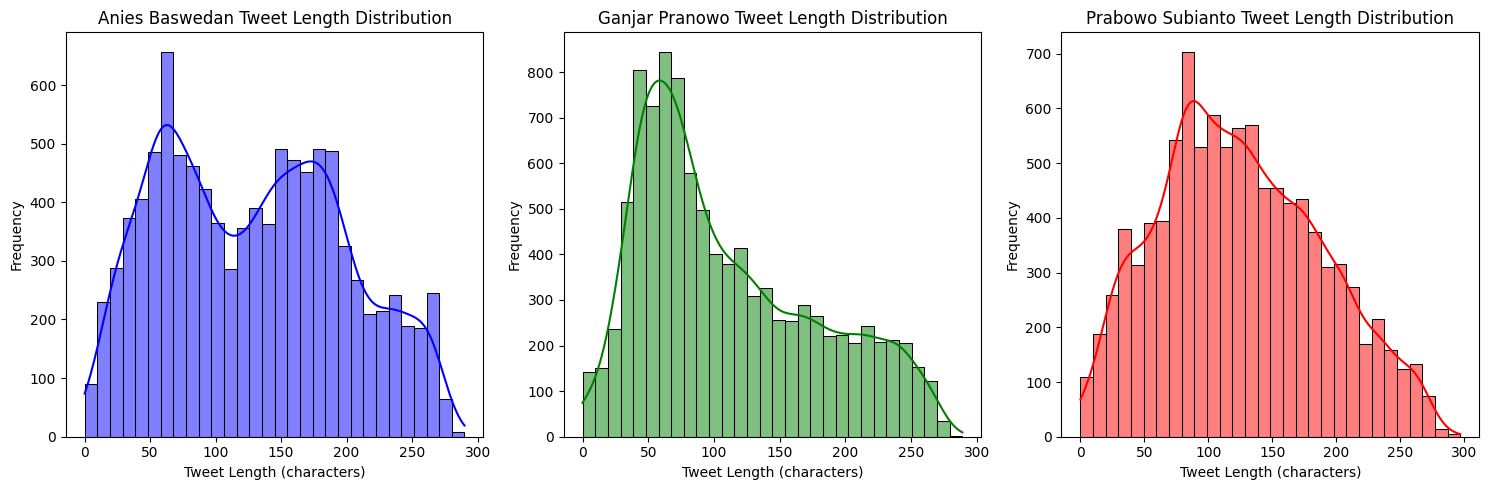

In [7]:
# Buat direktori output untuk gambar jika belum ada
os.makedirs('/kaggle/working/pictures', exist_ok=True)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_anies['tweet_length'], bins=30, kde=True, color='blue')
plt.title('Anies Baswedan Tweet Length Distribution')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(df_ganjar['tweet_length'], bins=30, kde=True, color='green')
plt.title('Ganjar Pranowo Tweet Length Distribution')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(df_prabowo['tweet_length'], bins=30, kde=True, color='red')
plt.title('Prabowo Subianto Tweet Length Distribution')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')

plt.tight_layout()

plt.savefig(os.path.join(PICTURES_DIR, 'tweet_length.png'))
plt.show()


## Duplicate Tweets

In [8]:
print('--- Duplicated Tweets for Anies Baswedan ---')
duplicate_anies_tweets = df_anies['Tweet'].value_counts()
duplicate_anies_tweets = duplicate_anies_tweets[duplicate_anies_tweets > 1]
print(duplicate_anies_tweets.head(10))

--- Duplicated Tweets for Anies Baswedan ---
Tweet
anies presiden                                                                                                                            76
anies presiden ri                                                                                                                         40
catetttttt yee druunn asmara anies didu saewad idha sir                                                                                   38
anies ahy insya allah presiden ri dan wakil presiden ri di aamiin                                                                         26
catetttttt yee druunn asmara aja anies didu saewad idha sir                                                                               24
catetttttt yee drunnn asmara aja anies didu saewad idha sir                                                                               21
salam perubahan dan pebaikan untuk indonesia lebih baik demokrat jaya pancasila abadi anies baswedan ah

In [9]:
print('\n--- Duplicated Tweets for Ganjar Pranowo ---')
duplicate_ganjar_tweets = df_ganjar['Tweet'].value_counts()
duplicate_ganjar_tweets = duplicate_ganjar_tweets[duplicate_ganjar_tweets > 1]
print(duplicate_ganjar_tweets.head(10))


--- Duplicated Tweets for Ganjar Pranowo ---
Tweet
makganjar sulawesi selatan berbagi kebaikan                                59
dukung ganjar untuk menjadi presiden pranowo                               50
ganjar pranowo pantas jadi presiden pranowo                                48
bismillah yok pak ganjar for presiden pranowo                              47
kita kawal ganjar for presiden pranowo                                     47
ganjar presiden                                                            32
dukung ganjar presiden ganjar pranowo bersih for ganjar terbaik pranowo    31
ganjar calon presiden pranowo                                              30
ganjar for presiden                                                        30
dukung ganjar pranowo sebagai presiden indonesia tahun pranowo             25
Name: count, dtype: int64


In [10]:
print('--- Duplicated Tweets for Prabowo Subianto ---')
duplicate_prabowo_tweets = df_prabowo['Tweet'].value_counts()
duplicate_prabowo_tweets = duplicate_prabowo_tweets[duplicate_prabowo_tweets > 1]
print(duplicate_prabowo_tweets.head(10))

--- Duplicated Tweets for Prabowo Subianto ---
Tweet
prabowo presiden                                                                                   109
prabowo subianto presiden                                                                           73
saat jalan sehat di samarinda gerindra kaltim dukung prabowo subianto jadi calon presiden           51
al quran allah muhammad anies baswedan presiden prabowo sandiaga uno ustad islam muslim             46
jalan sehat di samarinda gerindra kaltim dukung prabowo subianto jadi calon presiden                44
bismillah pak prabowo subianto presiden                                                             40
gerindra kaltim dukung prabowo subianto jadi calon presiden                                         31
prabowo subianto terbaik presiden                                                                   28
insyaallah mba nana paham sudah bismillah presiden tulis linanta prabowo subianto                   24
update hasil survei 

In [11]:
print('--- Characteristics of Most Duplicated Tweet for Anies Baswedan ---')
most_duplicated_anies_tweet_text = duplicate_anies_tweets.index[0]
print(f"Most duplicated tweet: '{most_duplicated_anies_tweet_text}'")

# Filter df_anies for the most duplicated tweet
filtered_anies_duplicates = df_anies[df_anies['Tweet'] == most_duplicated_anies_tweet_text]

# Display descriptive statistics for relevant columns
print('\nDescriptive statistics for ' + most_duplicated_anies_tweet_text + ' related tweets:')
print(filtered_anies_duplicates[['Followers', 'Following', 'Tweet Count']].describe())

--- Characteristics of Most Duplicated Tweet for Anies Baswedan ---
Most duplicated tweet: 'anies presiden'

Descriptive statistics for anies presiden related tweets:
         Followers    Following   Tweet Count
count    76.000000    76.000000     76.000000
mean    236.000000   502.000000   2976.289474
std     409.978308   609.336645   6765.118334
min       0.000000     2.000000      3.000000
25%      29.000000   151.000000    683.750000
50%      38.000000   250.000000   1036.000000
75%     265.000000   536.000000   2554.250000
max    1880.000000  3052.000000  53907.000000


In [12]:
print('\n--- Characteristics of Most Duplicated Tweet for Ganjar Pranowo ---')
most_duplicated_ganjar_tweet_text = duplicate_ganjar_tweets.index[0]
print(f"Most duplicated tweet: '{most_duplicated_ganjar_tweet_text}'")

# Filter df_ganjar for the most duplicated tweet
filtered_ganjar_duplicates = df_ganjar[df_ganjar['Tweet'] == most_duplicated_ganjar_tweet_text]

# Display descriptive statistics for relevant columns
print('\nDescriptive statistics for ' + most_duplicated_ganjar_tweet_text + ' related tweets:')
print(filtered_ganjar_duplicates[['Followers', 'Following', 'Tweet Count']].describe())


--- Characteristics of Most Duplicated Tweet for Ganjar Pranowo ---
Most duplicated tweet: 'makganjar sulawesi selatan berbagi kebaikan'

Descriptive statistics for makganjar sulawesi selatan berbagi kebaikan related tweets:
       Followers  Following  Tweet Count
count       59.0       59.0         59.0
mean        33.0       33.0        122.0
std          0.0        0.0          0.0
min         33.0       33.0        122.0
25%         33.0       33.0        122.0
50%         33.0       33.0        122.0
75%         33.0       33.0        122.0
max         33.0       33.0        122.0


In [13]:
print('\n--- Characteristics of Most Duplicated Tweet for Prabowo Subianto ---')
most_duplicated_prabowo_tweet_text = duplicate_prabowo_tweets.index[0]
print(f"Most duplicated tweet: '{most_duplicated_prabowo_tweet_text}'")

# Filter df_prabowo for the most duplicated tweet
filtered_prabowo_duplicates = df_prabowo[df_prabowo['Tweet'] == most_duplicated_prabowo_tweet_text]

# Display descriptive statistics for relevant columns
print('\nDescriptive statistics for ' + most_duplicated_prabowo_tweet_text + ' related tweets:')
print(filtered_prabowo_duplicates[['Followers', 'Following', 'Tweet Count']].describe())


--- Characteristics of Most Duplicated Tweet for Prabowo Subianto ---
Most duplicated tweet: 'prabowo presiden'

Descriptive statistics for prabowo presiden related tweets:
          Followers    Following    Tweet Count
count    109.000000   109.000000     109.000000
mean     587.944954   405.550459   10179.990826
std     1802.030449   691.505610   17251.710695
min        0.000000     0.000000       2.000000
25%        5.000000    39.000000     122.000000
50%      448.000000   524.000000   15021.000000
75%      448.000000   524.000000   15021.000000
max    15931.000000  6597.000000  155034.000000


/tmp/ipykernel_19/3998271908.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


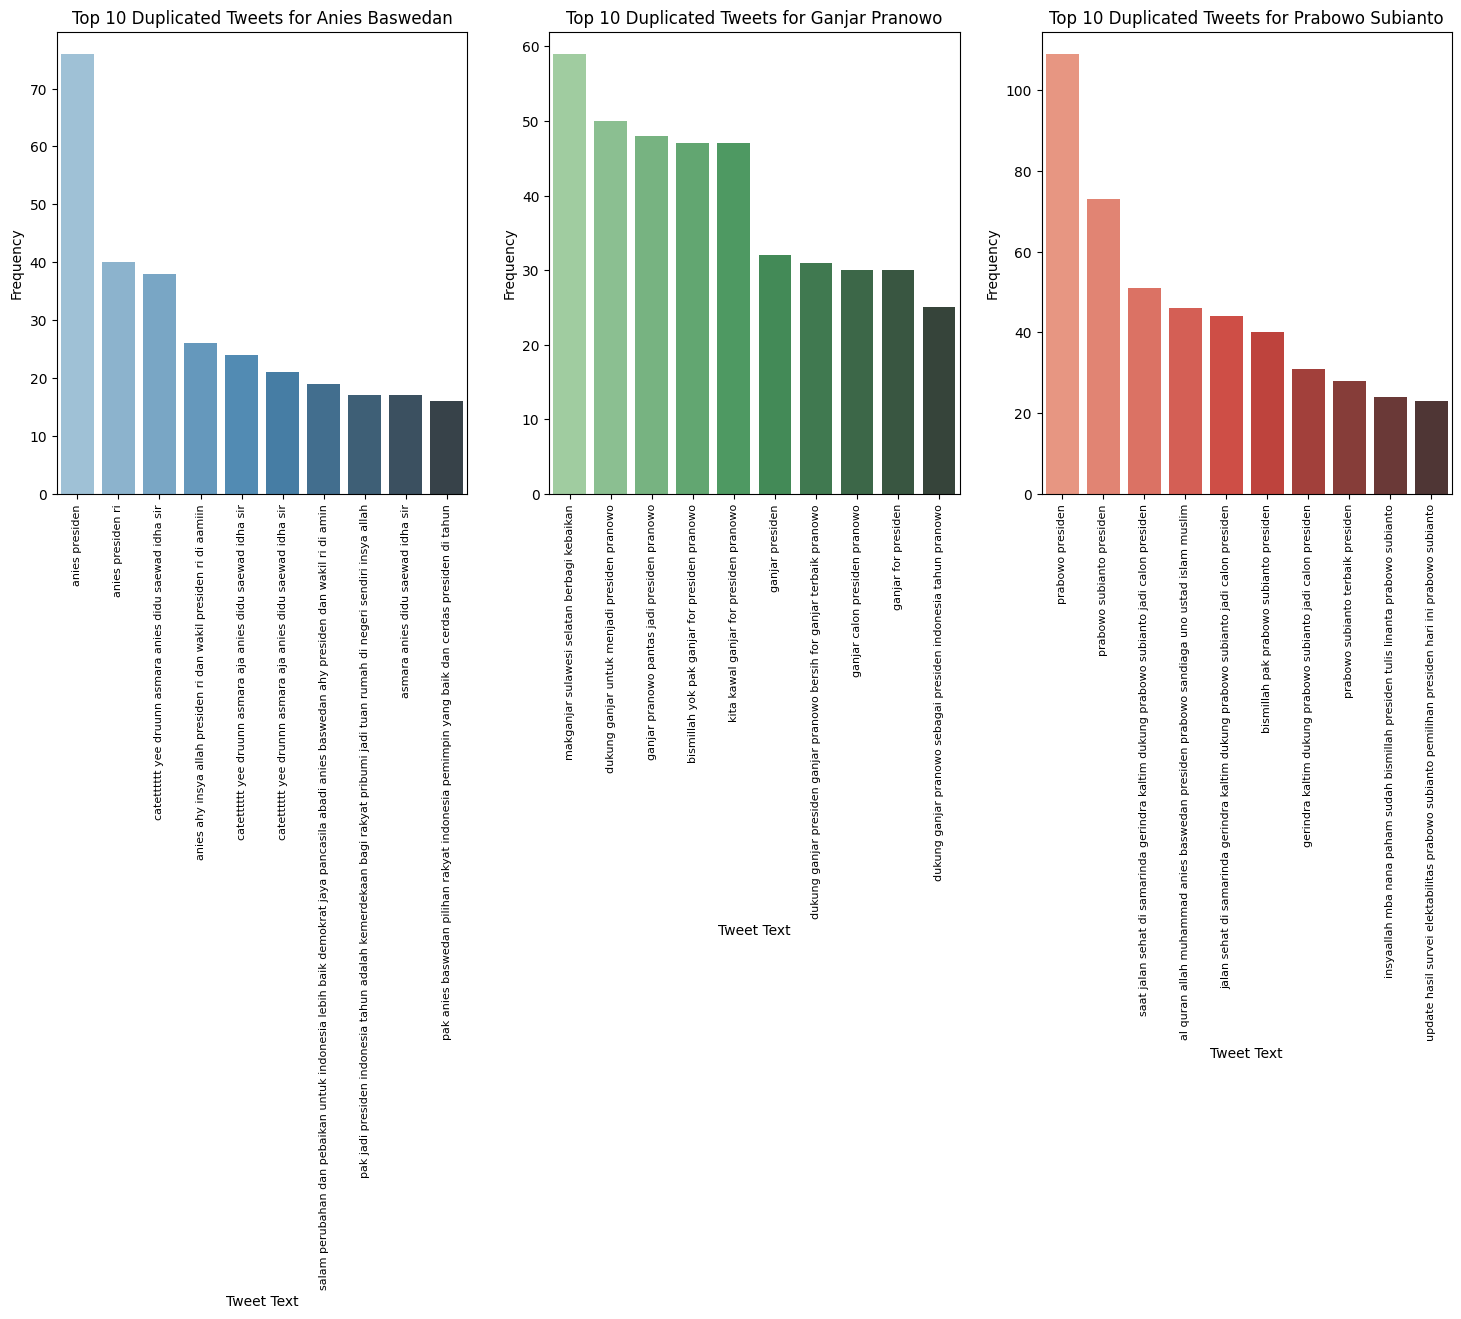

In [14]:
# Buat direktori output untuk gambar jika belum ada
os.makedirs('/kaggle/working/pictures', exist_ok=True)

# Visualize Top 10 Duplicated Tweets for each candidate
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x=duplicate_anies_tweets.head(10).index, y=duplicate_anies_tweets.head(10).values, palette='Blues_d')
plt.title('Top 10 Duplicated Tweets for Anies Baswedan')
plt.xlabel('Tweet Text')
plt.ylabel('Frequency')
plt.xticks(rotation=90, fontsize=8)

plt.subplot(1, 3, 2)
sns.barplot(x=duplicate_ganjar_tweets.head(10).index, y=duplicate_ganjar_tweets.head(10).values, palette='Greens_d')
plt.title('Top 10 Duplicated Tweets for Ganjar Pranowo')
plt.xlabel('Tweet Text')
plt.ylabel('Frequency')
plt.xticks(rotation=90, fontsize=8)

plt.subplot(1, 3, 3)
sns.barplot(x=duplicate_prabowo_tweets.head(10).index, y=duplicate_prabowo_tweets.head(10).values, palette='Reds_d')
plt.title('Top 10 Duplicated Tweets for Prabowo Subianto')
plt.xlabel('Tweet Text')
plt.ylabel('Frequency')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()

plt.savefig(os.path.join(PICTURES_DIR, 'duplicate_tweets.png'))
plt.show()

## Boxplot

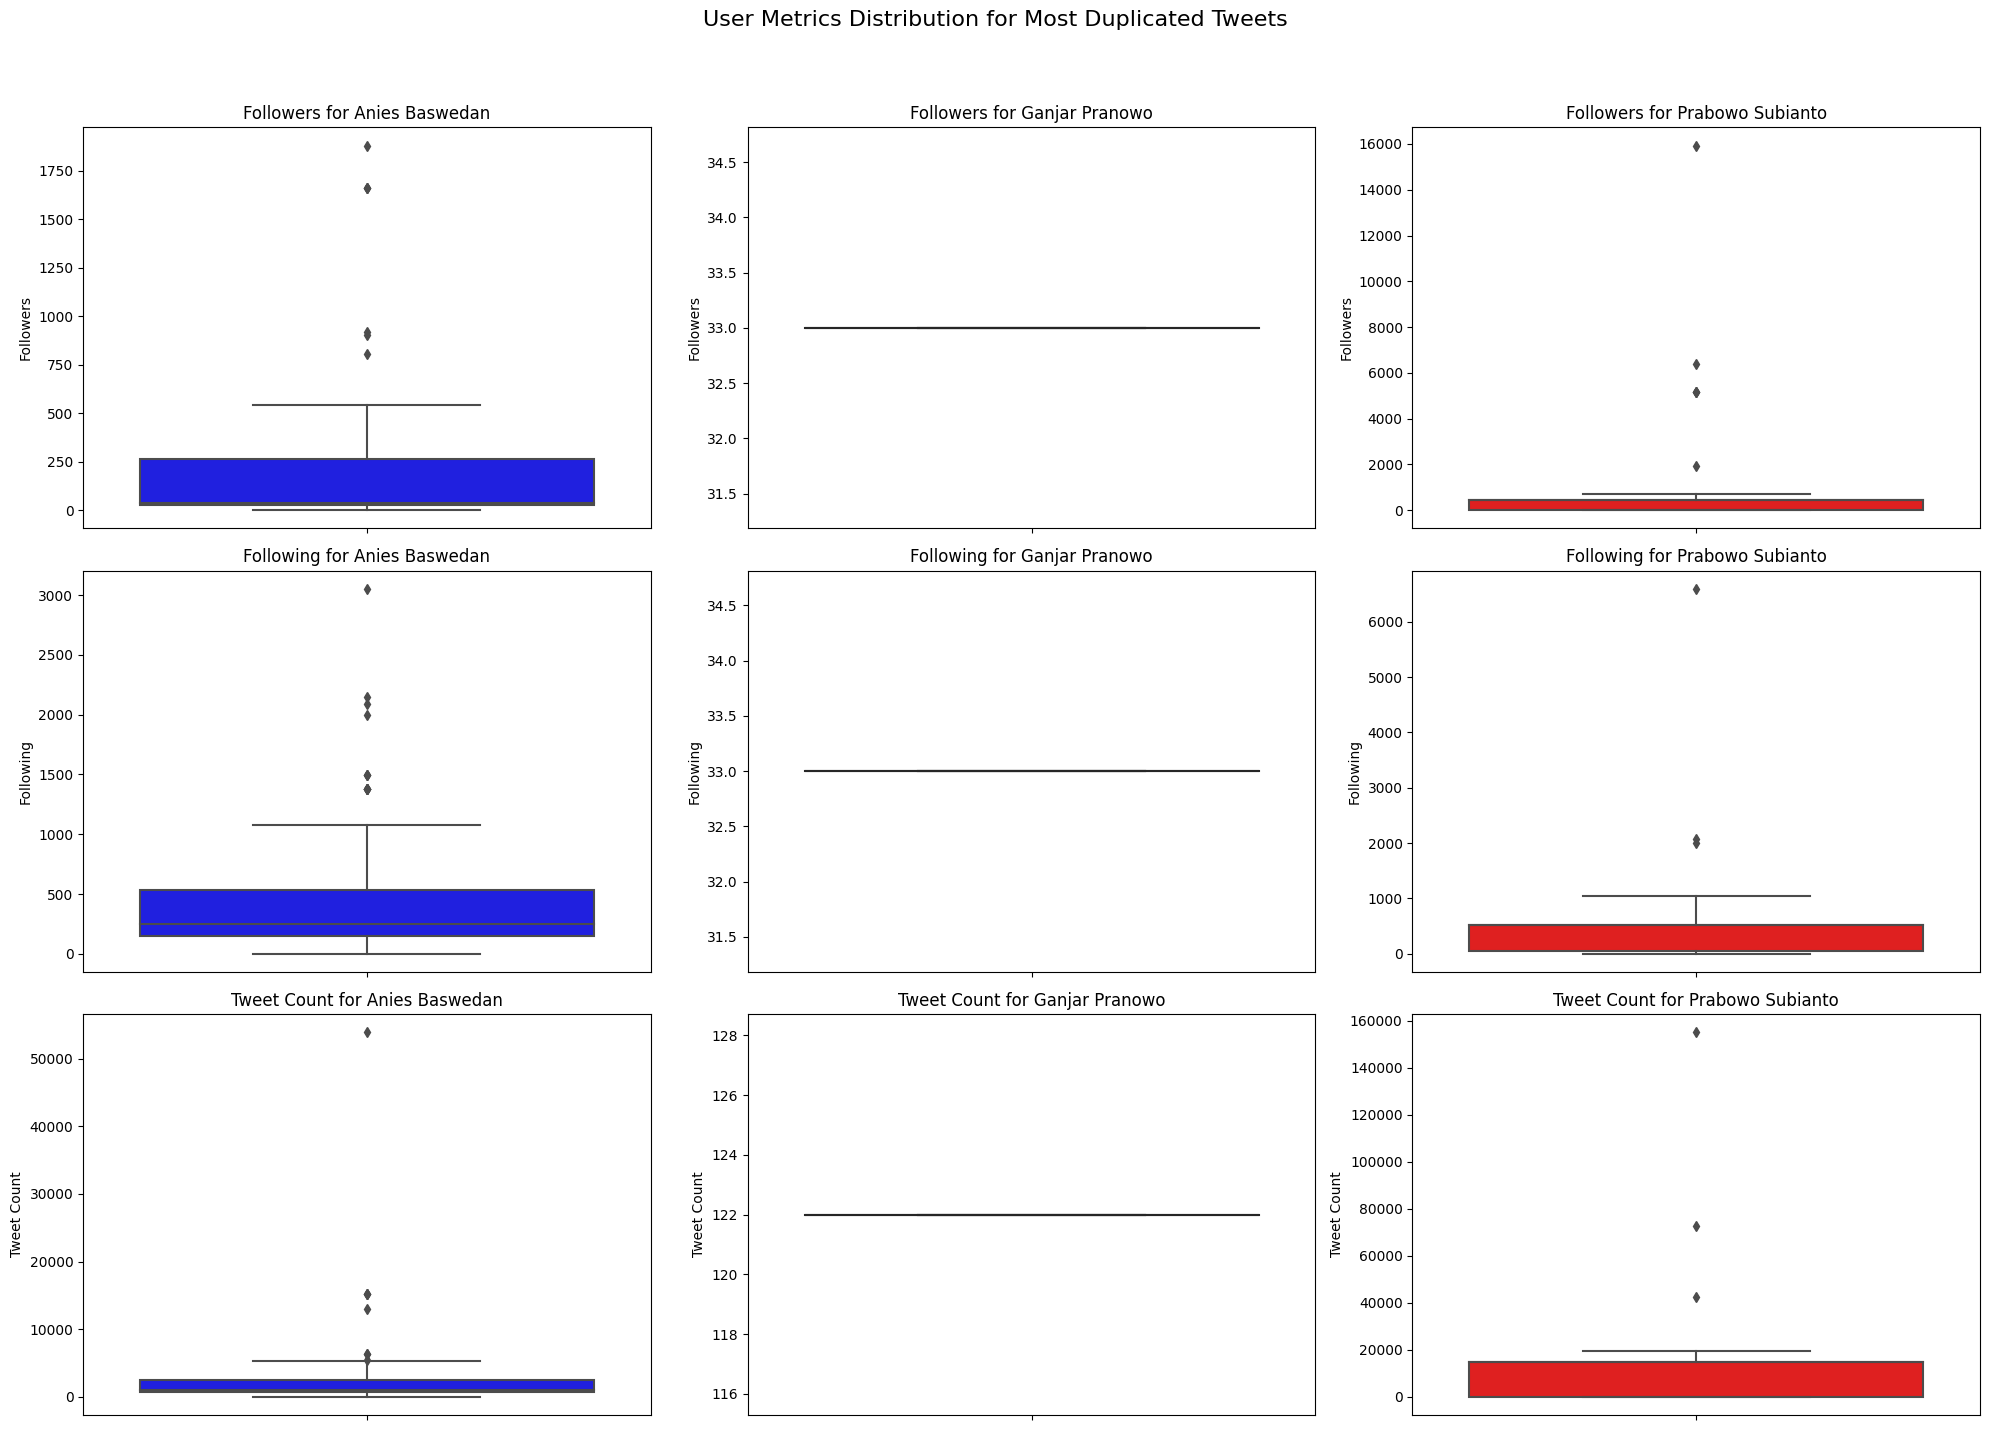

In [15]:
# Buat direktori output untuk gambar jika belum ada
os.makedirs('/kaggle/working/pictures', exist_ok=True)

# Prepare data for plotting
user_metrics = ['Followers', 'Following', 'Tweet Count']
candidates_data = {
    'Anies Baswedan': filtered_anies_duplicates,
    'Ganjar Pranowo': filtered_ganjar_duplicates,
    'Prabowo Subianto': filtered_prabowo_duplicates
}
colors = {'Anies Baswedan': 'blue', 'Ganjar Pranowo': 'green', 'Prabowo Subianto': 'red'}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.suptitle('User Metrics Distribution for Most Duplicated Tweets', fontsize=16)

for i, candidate_name in enumerate(candidates_data.keys()):
    df = candidates_data[candidate_name]
    for j, metric in enumerate(user_metrics):
        sns.boxplot(y=df[metric], ax=axes[j, i], color=colors[candidate_name])
        axes[j, i].set_title(f'{metric} for {candidate_name}')
        axes[j, i].set_ylabel(metric)
        axes[j, i].set_xlabel('') # Remove x-label as there's only one box per subplot

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap

plt.savefig(os.path.join(PICTURES_DIR, 'boxplot.png'))
plt.show()

## Data Cleaning
1.  **Drop Missing Values**: Removing rows where the tweet content is NaN.
2.  **Drop Duplicates**: Removing duplicate tweets to eliminate noise (e.g., buzzers, spam) and ensure the sentiment analysis reflects diverse opinions.

In [16]:
# Function to clean dataframe
def clean_data(df, name):
    print(f"--- Cleaning {name} ---")
    initial_count = len(df)
    
    # 1. Drop NaN
    df_clean = df.dropna(subset=['Tweet'])
    nan_dropped = initial_count - len(df_clean)
    
    # 2. Drop Duplicates
    df_clean = df_clean.drop_duplicates(subset=['Tweet'])
    dup_dropped = initial_count - nan_dropped - len(df_clean)
    
    print(f"Initial: {initial_count}")
    print(f"Dropped NaN: {nan_dropped}")
    print(f"Dropped Duplicates: {dup_dropped}")
    print(f"Final: {len(df_clean)}")
    return df_clean

# Apply cleaning
df_anies = clean_data(df_anies, 'Anies Baswedan')
df_ganjar = clean_data(df_ganjar, 'Ganjar Pranowo')
df_prabowo = clean_data(df_prabowo, 'Prabowo Subianto')

--- Cleaning Anies Baswedan ---
Initial: 10000
Dropped NaN: 66
Dropped Duplicates: 1035
Final: 8899
--- Cleaning Ganjar Pranowo ---
Initial: 10000
Dropped NaN: 115
Dropped Duplicates: 1980
Final: 7905
--- Cleaning Prabowo Subianto ---
Initial: 10000
Dropped NaN: 88
Dropped Duplicates: 3097
Final: 6815


## WordCloud of Stopwords
Visualizing the **stopwords** present in the original tweets. This helps in deciding which words to exclude from the stopword list.

Loaded 757 stopwords.
--- Stopword Cloud for Anies Baswedan ---
Gambar disimpan ke: /kaggle/working/pictures/anies_baswedan_stopword_cloud.png


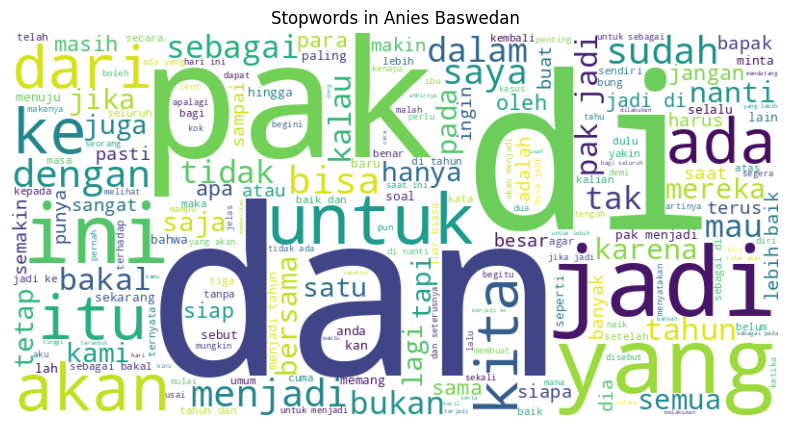

--- Stopword Cloud for Ganjar Pranowo ---
Gambar disimpan ke: /kaggle/working/pictures/ganjar_pranowo_stopword_cloud.png


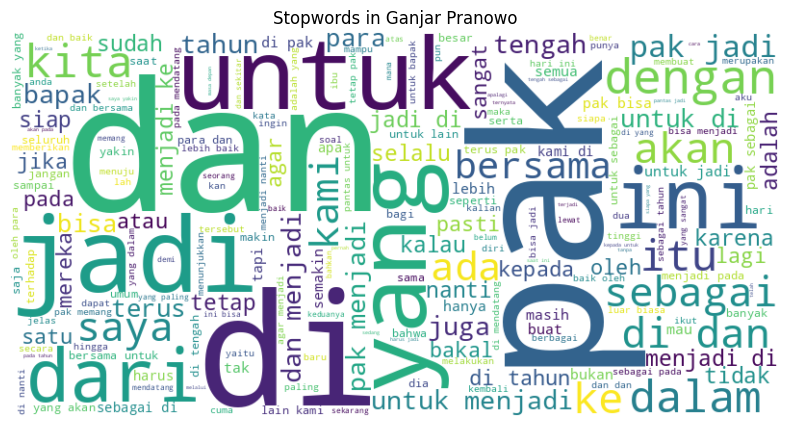

--- Stopword Cloud for Prabowo Subianto ---
Gambar disimpan ke: /kaggle/working/pictures/prabowo_subianto_stopword_cloud.png


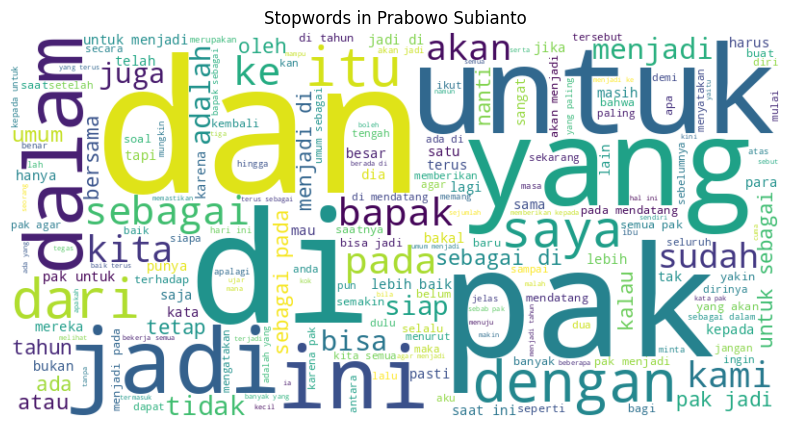

In [17]:
# Buat direktori output untuk gambar jika belum ada
os.makedirs('/kaggle/working/pictures', exist_ok=True)

# Load Stopwords dari CSV
# Kita baca menggunakan pandas, ambil kolom pertama, dan ubah jadi set
try:
    # Coba baca tanpa header (asumsi baris pertama adalah data)
    df_stop = pd.read_csv('/kaggle/input/indonesian-stoplist/stopwordbahasa.csv', header=None)
    stopwords_set = set(df_stop[0].astype(str).str.strip().tolist())
except:
    # Fallback: jika gagal, mungkin ada header, coba baca normal
    df_stop = pd.read_csv('/kaggle/input/indonesian-stoplist/stopwordbahasa.csv')
    stopwords_set = set(df_stop.iloc[:, 0].astype(str).str.strip().tolist())

print(f"Loaded {len(stopwords_set)} stopwords.")

def generate_stopword_cloud(text_series, title):
    # Combine all text
    all_text = ' '.join(text_series.fillna('').astype(str).tolist())
    
    # Filter to keep ONLY stopwords
    words = all_text.lower().split()
    stopword_only_text = ' '.join([word for word in words if word in stopwords_set])
    
    if not stopword_only_text:
        print(f"No stopwords found in {title}.")
        return

    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(stopword_only_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Stopwords in {title}')

    # Simpan ke /kaggle/working/pictures dengan nama file yang aman
    safe_filename = title.replace(' ', '_').lower() + '_stopword_cloud.png'
    save_path = os.path.join(PICTURES_DIR, safe_filename)
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Gambar disimpan ke: {save_path}")
    
    plt.show()

print("--- Stopword Cloud for Anies Baswedan ---")
generate_stopword_cloud(df_anies['Tweet'], 'Anies Baswedan')

print("--- Stopword Cloud for Ganjar Pranowo ---")
generate_stopword_cloud(df_ganjar['Tweet'], 'Ganjar Pranowo')

print("--- Stopword Cloud for Prabowo Subianto ---")
generate_stopword_cloud(df_prabowo['Tweet'], 'Prabowo Subianto')

# **PREPROCESSING**

1. **Text Normalization**: Converting slang/colloquial words to formal Indonesian using `colloquial-indonesian-lexicon.csv`.
2. **Stopword Removal**: Removing common words using `tala-stopwords-indonesia.txt`, with specific exclusions (negations, etc.).
3. **Stemming**: Reducing words to their root form using `Sastrawi`.
4. **Branching**: Creating 4 dataset variations for comparison:
    * Normalized + No Stemming
    * Normalized + Stemmed
    * No Normalization + No Stemming
    * No Normalization + Stemmed

## Helper Function

In [18]:
def load_stopwords(filepath):
    # Cek apakah file berupa CSV (Format Kaggle)
    if filepath.endswith('.csv'):
        try:
            # Baca CSV tanpa header, ambil kolom pertama
            df = pd.read_csv(filepath, header=None)
            stopwords = set(df[0].astype(str).str.strip().tolist())
        except:
            # Fallback: jika gagal, coba baca dengan header default
            df = pd.read_csv(filepath)
            stopwords = set(df.iloc[:, 0].astype(str).str.strip().tolist())
    else:
        # Baca file TXT biasa (Format Lokal)
        with open(filepath, 'r') as f:
            stopwords = set(line.strip() for line in f)
    
    # Exclude specific words (Negations, Intensifiers, Modals, Trust)
    excluded_words = {
        'tidak', 'bukan', 'belum', 'jangan', 'tak', 'enggak',
        'lebih', 'kurang', 'terlalu',
        'bisa', 'mampu', 'mau', 'harus',
        'yakin', 'percaya'
    }
    
    # Hapus kata-kata yang dikecualikan dari set stopwords
    return stopwords - excluded_words

def load_normalization_dict(filepath):
    if not os.path.exists(filepath):
        print(f"Lexicon file not found at: {filepath}")
        return {}
    df_lexicon = pd.read_csv(filepath)
    return dict(zip(df_lexicon['slang'], df_lexicon['formal']))

def normalize_text(text, norm_dict):
    if not isinstance(text, str): return str(text)
    words = text.split()
    normalized_words = [norm_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

def remove_stopwords(text, stopwords):
    if not isinstance(text, str): return ""
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return " ".join(filtered_words)

def apply_stemming(text, stemmer):
    if not isinstance(text, str): return ""
    return stemmer.stem(text)

# Load Resources
stopwords_ind = load_stopwords(STOPWORD_FILE)
norm_dict = load_normalization_dict(LEXICON_FILE)
factory = StemmerFactory()
stemmer_ind = factory.create_stemmer()

print(f"Resources loaded: {len(stopwords_ind)} stopwords, {len(norm_dict)} normalization entries.")

Resources loaded: 743 stopwords, 4331 normalization entries.


## Normalization, Stopword Removal, & Stemming

In [19]:
# Execute Indonesian Processing for SKENARIO 2
# Dataset A: WITH STEMMING (normalized_stemmed)
# Dataset B: WITHOUT STEMMING (normalized only)

candidates = {
    'anies': df_anies, 
    'ganjar': df_ganjar, 
    'prabowo': df_prabowo
}

for name, df in candidates.items():
    print(f"Processing {name} for Skenario 2...")
    
    # Output Paths
    # Dataset B (Without Stemming) - normalized only
    path_normalized = os.path.join(PROCESSED_DIR, f'{name}_normalized.csv')
    
    # Dataset A (With Stemming) - normalized + stemmed  
    path_norm_stemmed = os.path.join(PROCESSED_DIR, f'{name}_normalized_stemmed.csv')
    
    # Base: Lowercase
    df_base = df.copy()
    df_base['Tweet'] = df_base['Tweet'].astype(str).str.lower()

    # Check Pre-computed Helper
    def check_precomputed(filename, dest_path):
        src_path = os.path.join(PRECOMPUTED_DIR, filename)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
            print(f"  ✓ Loaded pre-computed: {filename}")
            return True
        return False
        
    # === DATASET B: WITHOUT STEMMING (Normalized Only) ===
    check_precomputed(f'{name}_normalized.csv', path_normalized)

    if not os.path.exists(path_normalized):
        print(f"  Creating Dataset B (Without Stemming) for {name}...")
        df_b = df_base.copy()
        df_b['Tweet'] = df_b['Tweet'].apply(lambda x: normalize_text(x, norm_dict))
        df_b['Tweet'] = df_b['Tweet'].apply(lambda x: remove_stopwords(x, stopwords_ind))
        df_b.to_csv(path_normalized, index=False)
        print(f"  ✓ Dataset B Saved: {path_normalized}")

    # === DATASET A: WITH STEMMING (Normalized + Stemmed) ===
    check_precomputed(f'{name}_normalized_stemmed.csv', path_norm_stemmed)

    if not os.path.exists(path_norm_stemmed):
        print(f"  Creating Dataset A (With Stemming) for {name}...")
        df_a = df_base.copy()
        df_a['Tweet'] = df_a['Tweet'].apply(lambda x: normalize_text(x, norm_dict))
        df_a['Tweet'] = df_a['Tweet'].apply(lambda x: remove_stopwords(x, stopwords_ind))
        df_a['Tweet'] = df_a['Tweet'].apply(lambda x: apply_stemming(x, stemmer_ind))
        df_a.to_csv(path_norm_stemmed, index=False)
        print(f"  ✓ Dataset A Saved: {path_norm_stemmed}")

print("\n" + "="*60)
print("PREPROCESSING COMPLETE FOR SKENARIO 2")
print("="*60)
print("Dataset A (With Stemming): normalized_stemmed.csv")
print("Dataset B (Without Stemming): normalized.csv")
print("="*60)

Processing anies for Skenario 2...
  ✓ Loaded pre-computed: anies_normalized.csv
  ✓ Loaded pre-computed: anies_normalized_stemmed.csv
Processing ganjar for Skenario 2...
  ✓ Loaded pre-computed: ganjar_normalized.csv
  ✓ Loaded pre-computed: ganjar_normalized_stemmed.csv
Processing prabowo for Skenario 2...
  ✓ Loaded pre-computed: prabowo_normalized.csv
  ✓ Loaded pre-computed: prabowo_normalized_stemmed.csv

PREPROCESSING COMPLETE FOR SKENARIO 2
Dataset A (With Stemming): normalized_stemmed.csv
Dataset B (Without Stemming): normalized.csv


# **LABELING**
1. **InSet Lexicon**: For Indonesian (Normalized+Stemmed).
2. **VADER Lexicon**: For English.

## InSet Labeling

In [20]:
# Load InSet Lexicon
def load_inset(pos_path, neg_path):
    lexicon = {}
    try:
        pos = pd.read_csv(pos_path, sep='\t')
        neg = pd.read_csv(neg_path, sep='\t')
        for _, r in pos.iterrows(): lexicon[r['word']] = r['weight']
        for _, r in neg.iterrows(): lexicon[r['word']] = r['weight']
    except Exception as e:
        print(f"Error loading InSet: {e}")
    return lexicon

inset_lexicon = load_inset(
    '/kaggle/input/indo-sentiment-lexicon/positive.tsv', 
    '/kaggle/input/indo-sentiment-lexicon/negative.tsv'
)
print(f"✓ Loaded InSet Lexicon with {len(inset_lexicon)} words.")

# InSet Labeling Function
def label_inset(text, lexicon):
    score = 0
    if isinstance(text, str):
        for word in text.split():
            score += lexicon.get(word, 0)
    return 1 if score > 0 else (0 if score < 0 else -1)

print("\n" + "="*60)
print("LABELING UNTUK SKENARIO 2")
print("="*60)

# Execution for BOTH Datasets (A and B)
for name in ['anies', 'ganjar', 'prabowo']:
    print(f"\nProcessing {name}...")
    
    # === DATASET A: WITH STEMMING ===
    path_stemmed_in = os.path.join(PROCESSED_DIR, f'{name}_normalized_stemmed.csv')
    path_stemmed_out = os.path.join(LABELED_DIR, f'{name}_inset_stemmed.csv')
    
    if os.path.exists(path_stemmed_in):
        df_a = pd.read_csv(path_stemmed_in)
        df_a['Label_InSet'] = df_a['Tweet'].apply(lambda x: label_inset(x, inset_lexicon))
        df_a.to_csv(path_stemmed_out, index=False)
        print(f"  ✓ Dataset A (With Stemming) labeled. Saved to: {path_stemmed_out}")
    
    # === DATASET B: WITHOUT STEMMING ===
    path_no_stem_in = os.path.join(PROCESSED_DIR, f'{name}_normalized.csv')
    path_no_stem_out = os.path.join(LABELED_DIR, f'{name}_inset_no_stemming.csv')
    
    if os.path.exists(path_no_stem_in):
        df_b = pd.read_csv(path_no_stem_in)
        df_b['Label_InSet'] = df_b['Tweet'].apply(lambda x: label_inset(x, inset_lexicon))
        df_b.to_csv(path_no_stem_out, index=False)
        print(f"  ✓ Dataset B (Without Stemming) labeled. Saved to: {path_no_stem_out}")

print("\n" + "="*60)
print("LABELING COMPLETE")
print("="*60)

✓ Loaded InSet Lexicon with 9074 words.

LABELING UNTUK SKENARIO 2

Processing anies...
  ✓ Dataset A (With Stemming) labeled. Saved to: /kaggle/working/labeled/anies_inset_stemmed.csv
  ✓ Dataset B (Without Stemming) labeled. Saved to: /kaggle/working/labeled/anies_inset_no_stemming.csv

Processing ganjar...
  ✓ Dataset A (With Stemming) labeled. Saved to: /kaggle/working/labeled/ganjar_inset_stemmed.csv
  ✓ Dataset B (Without Stemming) labeled. Saved to: /kaggle/working/labeled/ganjar_inset_no_stemming.csv

Processing prabowo...
  ✓ Dataset A (With Stemming) labeled. Saved to: /kaggle/working/labeled/prabowo_inset_stemmed.csv
  ✓ Dataset B (Without Stemming) labeled. Saved to: /kaggle/working/labeled/prabowo_inset_no_stemming.csv

LABELING COMPLETE


## Label Visualization


GENERATING LABEL DISTRIBUTION VISUALIZATIONS


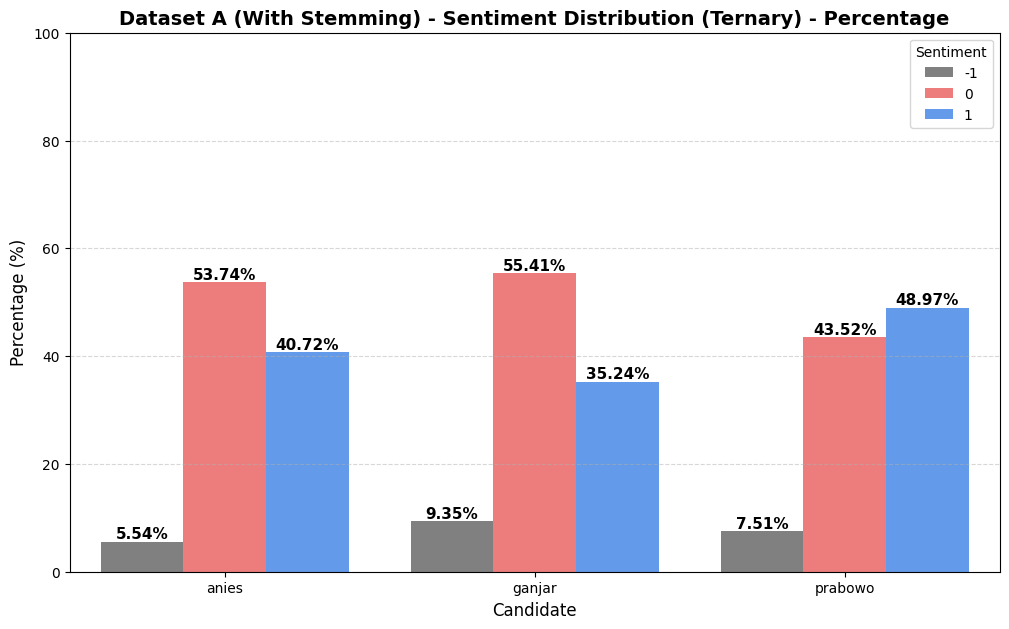

✓ Saved inset_dataset_a_(with_stemming)_ternary_percentage.png


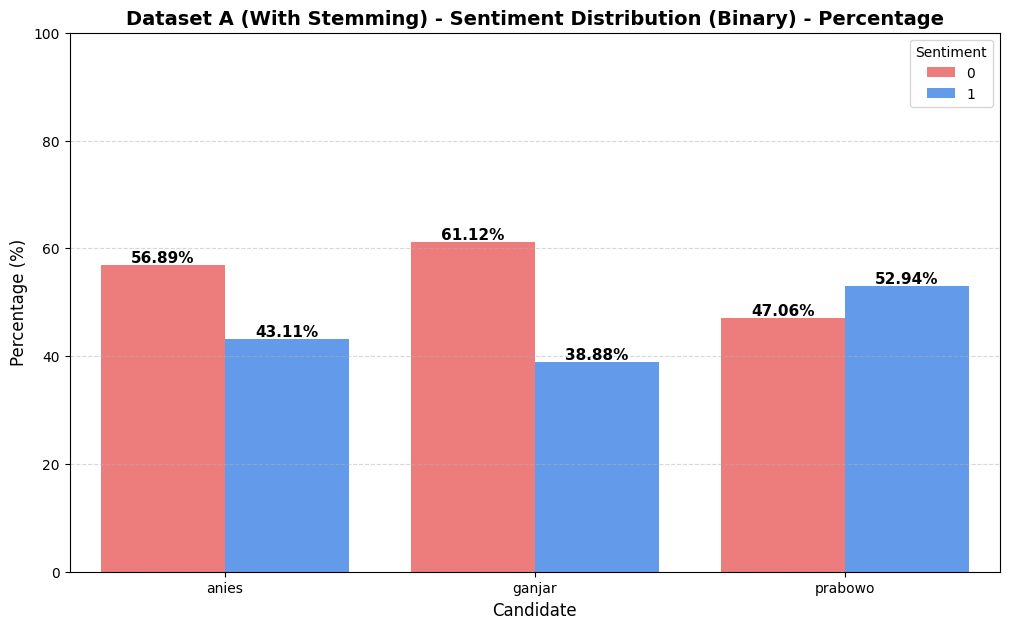

✓ Saved inset_dataset_a_(with_stemming)_binary_percentage.png


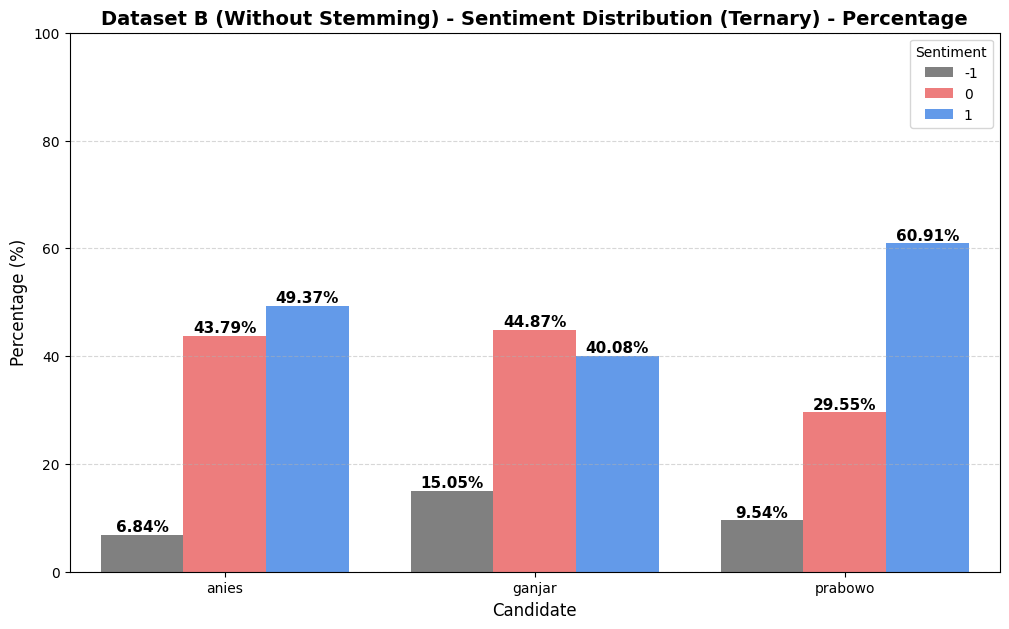

✓ Saved inset_dataset_b_(without_stemming)_ternary_percentage.png


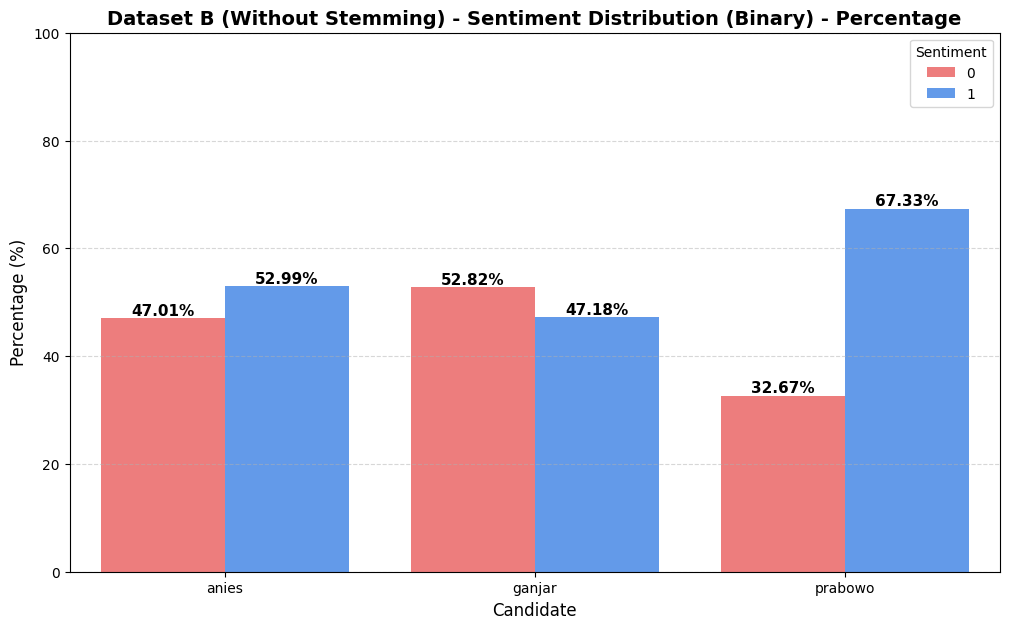

✓ Saved inset_dataset_b_(without_stemming)_binary_percentage.png
VISUALIZATION COMPLETE


In [21]:
# **BINARY REFINEMENT & VISUALIZATION - SKENARIO 2**

# Container for visualization data
vis_data_stemmed = []
vis_data_no_stem = []

for name in ['anies', 'ganjar', 'prabowo']:
    # --- DATASET A: WITH STEMMING ---
    input_path_stemmed = os.path.join(LABELED_DIR, f'{name}_inset_stemmed.csv')
    if os.path.exists(input_path_stemmed):
        df = pd.read_csv(input_path_stemmed)
        
        # Save Binary (Drop Neutral -1)
        df_binary = df[df['Label_InSet'] != -1].copy()
        df_binary.to_csv(os.path.join(LABELED_DIR, f'{name}_inset_stemmed_binary.csv'), index=False)
        
        # Add to vis data
        df['Candidate'] = name
        vis_data_stemmed.append(df[['Candidate', 'Label_InSet']])

    # --- DATASET B: WITHOUT STEMMING ---
    input_path_no_stem = os.path.join(LABELED_DIR, f'{name}_inset_no_stemming.csv')
    if os.path.exists(input_path_no_stem):
        df = pd.read_csv(input_path_no_stem)
        
        # Save Binary (Drop Neutral -1)
        df_binary = df[df['Label_InSet'] != -1].copy()
        df_binary.to_csv(os.path.join(LABELED_DIR, f'{name}_inset_no_stemming_binary.csv'), index=False)
        
         # Add to vis data
        df['Candidate'] = name
        vis_data_no_stem.append(df[['Candidate', 'Label_InSet']])

# --- Visualization Function ---
def plot_percentage_histogram(data_list, dataset_name, label_col):
    if not data_list:
        return
    
    df_all = pd.concat(data_list)
    
    # Define variants to plot: Ternary (with -1) and Binary (without -1)
    variants = [
        {'title': 'Ternary', 'df': df_all, 'palette': {-1: 'gray', 0: '#FF6B6B', 1: '#4D96FF'}},
        {'title': 'Binary', 'df': df_all[df_all[label_col] != -1], 'palette': {0: '#FF6B6B', 1: '#4D96FF'}}
    ]
    
    for var in variants:
        df_curr = var['df']
        if df_curr.empty: continue

        # Calculate Percentages
        counts = df_curr.groupby(['Candidate', label_col]).size().reset_index(name='Count')
        total_per_candidate = df_curr.groupby('Candidate').size().reset_index(name='Total')
        
        merged = pd.merge(counts, total_per_candidate, on='Candidate')
        merged['Percentage'] = (merged['Count'] / merged['Total']) * 100
        merged['Percentage'] = merged['Percentage'].round(2)
        
        # Plotting
        plt.figure(figsize=(12, 7))
        ax = sns.barplot(x='Candidate', y='Percentage', hue=label_col, data=merged, palette=var['palette'])
        
        plt.title(f'{dataset_name} - Sentiment Distribution ({var["title"]}) - Percentage', fontsize=14, fontweight='bold')
        plt.xlabel('Candidate', fontsize=12)
        plt.ylabel('Percentage (%)', fontsize=12)
        plt.ylim(0, 100)
        plt.legend(title='Sentiment')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Annotations
        for p in ax.patches:
            if p.get_height() > 0:
                ax.annotate(f'{p.get_height():.2f}%',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')
        
        filename = f'inset_{dataset_name.lower().replace(" ", "_")}_{var["title"].lower()}_percentage.png'
        plt.savefig(os.path.join(PICTURES_DIR, filename))
        plt.show()
        print(f"✓ Saved {filename}")

# Run Visualization
print("\n" + "="*60)
print("GENERATING LABEL DISTRIBUTION VISUALIZATIONS")
print("="*60)
plot_percentage_histogram(vis_data_stemmed, 'Dataset A (With Stemming)', 'Label_InSet')
plot_percentage_histogram(vis_data_no_stem, 'Dataset B (Without Stemming)', 'Label_InSet')
print("="*60)
print("VISUALIZATION COMPLETE")
print("="*60)

# **FEATURE EXTRACTION**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import scipy.sparse as sp

print("=" * 60)
print("FEATURE EXTRACTION - TF-IDF (SKENARIO 2)")
print("=" * 60)

# Function to load labeled data for Skenario 2
def load_labeled_data_sk2(dataset_type='stemmed'):
    """
    Load labeled data for all candidates
    dataset_type: 'stemmed' (Dataset A) or 'no_stemming' (Dataset B)
    """
    dfs = []
    for name in ['anies', 'ganjar', 'prabowo']:
        if dataset_type == 'stemmed':
            path = os.path.join(LABELED_DIR, f'{name}_inset_stemmed_binary.csv')
        else:  # no_stemming
            path = os.path.join(LABELED_DIR, f'{name}_inset_no_stemming_binary.csv')
        
        if os.path.exists(path):
            df = pd.read_csv(path)
            df['Candidate'] = name
            dfs.append(df[['Tweet', 'Label_InSet', 'Candidate']])
    
    if not dfs:
        print(f"No {dataset_type} labeled data found!")
        return None
    
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"\nDataset Type: {dataset_type.upper()}")
    print(f"Total samples: {len(combined_df)}")
    print(f"Label distribution:\n{combined_df['Label_InSet'].value_counts()}")
    return combined_df

# Feature Extraction Function
def extract_tfidf_features(df, label_col='Label_InSet', text_col='Tweet', max_features=5000, ngram_range=(1, 2)):
    """
    Extract TF-IDF features from text data
    """
    print(f"\n--- Extracting TF-IDF Features ---")
    print(f"Max features: {max_features}")
    print(f"N-gram range: {ngram_range}")
    
    # Prepare data
    X = df[text_col].fillna('')
    y = df[label_col]
    
    # Initialize TF-IDF Vectorizer
    tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )
    
    # Fit and transform
    X_tfidf = tfidf.fit_transform(X)
    
    print(f"TF-IDF shape: {X_tfidf.shape}")
    print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
    
    return X_tfidf, y, tfidf

# Train-Test Split Function
def split_dataset(X, y, test_size=0.2, random_state=42):
    """
    Split dataset into training and testing sets
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    print(f"\nTrain-Test Split:")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")
    print(f"Train label distribution:\n{pd.Series(y_train).value_counts()}")
    print(f"Test label distribution:\n{pd.Series(y_test).value_counts()}")
    
    return X_train, X_test, y_train, y_test

# === DATASET A: WITH STEMMING ===
print("\n" + "=" * 60)
print("PROCESSING DATASET A (WITH STEMMING)")
print("=" * 60)
df_stemmed = load_labeled_data_sk2(dataset_type='stemmed')

if df_stemmed is not None:
    X_stemmed, y_stemmed, tfidf_stemmed = extract_tfidf_features(df_stemmed, label_col='Label_InSet')
    
    # Save TF-IDF vectorizer
    with open(os.path.join(PROCESSED_DIR, 'tfidf_stemmed.pkl'), 'wb') as f:
        pickle.dump(tfidf_stemmed, f)
    print("✓ TF-IDF vectorizer saved (Dataset A)")
    
    # Display sample features
    feature_names = tfidf_stemmed.get_feature_names_out()
    print(f"\nSample features (Dataset A): {list(feature_names[:20])}")
    
    # Split dataset
    X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = split_dataset(X_stemmed, y_stemmed)
    
    # Save splits
    sp.save_npz(os.path.join(PROCESSED_DIR, 'X_train_stemmed.npz'), X_train_stemmed)
    sp.save_npz(os.path.join(PROCESSED_DIR, 'X_test_stemmed.npz'), X_test_stemmed)
    pd.Series(y_train_stemmed).to_csv(os.path.join(PROCESSED_DIR, 'y_train_stemmed.csv'), index=False, header=['label'])
    pd.Series(y_test_stemmed).to_csv(os.path.join(PROCESSED_DIR, 'y_test_stemmed.csv'), index=False, header=['label'])
    print("✓ Dataset A splits saved")

# === DATASET B: WITHOUT STEMMING ===
print("\n" + "=" * 60)
print("PROCESSING DATASET B (WITHOUT STEMMING)")
print("=" * 60)
df_no_stem = load_labeled_data_sk2(dataset_type='no_stemming')

if df_no_stem is not None:
    X_no_stem, y_no_stem, tfidf_no_stem = extract_tfidf_features(df_no_stem, label_col='Label_InSet')
    
    # Save TF-IDF vectorizer
    with open(os.path.join(PROCESSED_DIR, 'tfidf_no_stemming.pkl'), 'wb') as f:
        pickle.dump(tfidf_no_stem, f)
    print("✓ TF-IDF vectorizer saved (Dataset B)")
    
    # Display sample features
    feature_names = tfidf_no_stem.get_feature_names_out()
    print(f"\nSample features (Dataset B): {list(feature_names[:20])}")
    
    # Split dataset
    X_train_no_stem, X_test_no_stem, y_train_no_stem, y_test_no_stem = split_dataset(X_no_stem, y_no_stem)
    
    # Save splits
    sp.save_npz(os.path.join(PROCESSED_DIR, 'X_train_no_stemming.npz'), X_train_no_stem)
    sp.save_npz(os.path.join(PROCESSED_DIR, 'X_test_no_stemming.npz'), X_test_no_stem)
    pd.Series(y_train_no_stem).to_csv(os.path.join(PROCESSED_DIR, 'y_train_no_stemming.csv'), index=False, header=['label'])
    pd.Series(y_test_no_stem).to_csv(os.path.join(PROCESSED_DIR, 'y_test_no_stemming.csv'), index=False, header=['label'])
    print("✓ Dataset B splits saved")

print("\n" + "=" * 60)
print("FEATURE EXTRACTION COMPLETED FOR SKENARIO 2")
print("=" * 60)

FEATURE EXTRACTION - TF-IDF (SKENARIO 2)

PROCESSING DATASET A (WITH STEMMING)

Dataset Type: STEMMED
Total samples: 21875
Label distribution:
Label_InSet
0    12128
1     9747
Name: count, dtype: int64

--- Extracting TF-IDF Features ---
Max features: 5000
N-gram range: (1, 2)
TF-IDF shape: (21875, 5000)
Vocabulary size: 5000
✓ TF-IDF vectorizer saved (Dataset A)

Sample features (Dataset A): ['aalamiin', 'aalamiin moga', 'aalona', 'aamiinn', 'ab', 'abad', 'abad nu', 'abadi', 'abadi anies', 'abah', 'abai', 'abal', 'abang', 'abang becak', 'abdi', 'abdul', 'abu', 'abu janda', 'abud', 'abw']

Train-Test Split:
Training samples: 17500
Testing samples: 4375
Train label distribution:
Label_InSet
0    9702
1    7798
Name: count, dtype: int64
Test label distribution:
Label_InSet
0    2426
1    1949
Name: count, dtype: int64
✓ Dataset A splits saved

PROCESSING DATASET B (WITHOUT STEMMING)

Dataset Type: NO_STEMMING
Total samples: 21170
Label distribution:
Label_InSet
1    11712
0     9458
Nam

# **CLASSIFICATION MODELING**

In [23]:
from sklearn.model_selection import GridSearchCV

def tune_model(model, param_grid, X_train, y_train, model_name, candidate_name=''):
    print(f"\n🔍 Running HPT for {model_name} ...")
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1_weighted',
        cv=3,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    grid.fit(X_train, y_train)
    
    print(f"✓ Best params for {model_name}: {grid.best_params_}")
    print(f"✓ Best score: {grid.best_score_:.4f}")
    
    # Create results DataFrame
    cv_results = pd.DataFrame(grid.cv_results_)
    
    # Display top 5 configurations
    print(f"\n📊 Top 5 Configurations for {model_name}:")
    top_results = cv_results.nlargest(5, 'mean_test_score')[
        ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    ]
    print(top_results.to_string(index=False))
    
    # Visualize HPT results
    visualize_hpt_results(cv_results, model_name, candidate_name, param_grid)
    
    return grid.best_estimator_, cv_results

def visualize_hpt_results(cv_results, model_name, candidate_name, param_grid):
    """Visualize hyperparameter tuning results"""
    
    # Extract parameter columns
    param_cols = [col for col in cv_results.columns if col.startswith('param_')]
    
    if len(param_cols) == 0:
        return
    
    # Create visualization based on number of parameters
    if len(param_cols) == 1:
        # Single parameter - bar plot
        param_name = param_cols[0].replace('param_', '')
        
        plt.figure(figsize=(10, 6))
        
        # Sort by parameter value
        plot_data = cv_results.sort_values(param_cols[0])
        x_labels = [str(val) for val in plot_data[param_cols[0]]]
        
        bars = plt.bar(range(len(x_labels)), plot_data['mean_test_score'], 
                       color='skyblue', alpha=0.8, edgecolor='navy')
        plt.errorbar(range(len(x_labels)), plot_data['mean_test_score'], 
                    yerr=plot_data['std_test_score'], fmt='none', 
                    color='red', capsize=5, alpha=0.6)
        
        # Highlight best
        best_idx = plot_data['mean_test_score'].idxmax()
        best_pos = list(plot_data.index).index(best_idx)
        bars[best_pos].set_color('gold')
        bars[best_pos].set_edgecolor('darkgoldenrod')
        bars[best_pos].set_linewidth(2)
        
        plt.xlabel(param_name, fontsize=12, fontweight='bold')
        plt.ylabel('Mean F1-Score (CV)', fontsize=12, fontweight='bold')
        plt.title(f'HPT Results: {model_name}\n{candidate_name}', fontsize=14, fontweight='bold')
        plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        # Save
        safe_name = f"hpt_{candidate_name}_{model_name}".replace(' ', '_').replace('(', '').replace(')', '').lower()
        plt.savefig(os.path.join(PICTURES_DIR, f'{safe_name}.png'), dpi=150, bbox_inches='tight')
        plt.show()
        
    elif len(param_cols) == 2:
        # Two parameters - heatmap
        param1 = param_cols[0].replace('param_', '')
        param2 = param_cols[1].replace('param_', '')
        
        # Create pivot table
        pivot_data = cv_results.pivot_table(
            values='mean_test_score',
            index=param_cols[0],
            columns=param_cols[1],
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='YlGnBu', 
                    cbar_kws={'label': 'Mean F1-Score'}, linewidths=0.5)
        plt.xlabel(param2, fontsize=12, fontweight='bold')
        plt.ylabel(param1, fontsize=12, fontweight='bold')
        plt.title(f'HPT Heatmap: {model_name}\n{candidate_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        # Save
        safe_name = f"hpt_{candidate_name}_{model_name}".replace(' ', '_').replace('(', '').replace(')', '').lower()
        plt.savefig(os.path.join(PICTURES_DIR, f'{safe_name}.png'), dpi=150, bbox_inches='tight')
        plt.show()
        
    else:
        # Multiple parameters - parallel coordinates plot
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Score distribution
        axes[0].hist(cv_results['mean_test_score'], bins=20, color='skyblue', edgecolor='navy', alpha=0.7)
        axes[0].axvline(cv_results['mean_test_score'].max(), color='red', linestyle='--', 
                       linewidth=2, label=f"Best: {cv_results['mean_test_score'].max():.4f}")
        axes[0].set_xlabel('Mean F1-Score', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[0].set_title(f'Score Distribution: {model_name}', fontsize=12, fontweight='bold')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        # Plot 2: Top vs Bottom configurations
        top_5 = cv_results.nlargest(5, 'mean_test_score')
        bottom_5 = cv_results.nsmallest(5, 'mean_test_score')
        
        x_pos = range(5)
        axes[1].barh(x_pos, top_5['mean_test_score'].values, color='green', alpha=0.6, label='Top 5')
        axes[1].barh([i+6 for i in x_pos], bottom_5['mean_test_score'].values, color='red', alpha=0.6, label='Bottom 5')
        
        axes[1].set_yticks(list(x_pos) + [i+6 for i in x_pos])
        axes[1].set_yticklabels([f"Top {i+1}" for i in x_pos] + [f"Bottom {i+1}" for i in x_pos], fontsize=9)
        axes[1].set_xlabel('Mean F1-Score', fontsize=11, fontweight='bold')
        axes[1].set_title(f'Best vs Worst: {model_name}', fontsize=12, fontweight='bold')
        axes[1].legend()
        axes[1].grid(axis='x', alpha=0.3)
        
        plt.suptitle(f'HPT Analysis: {candidate_name}', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Save
        safe_name = f"hpt_{candidate_name}_{model_name}".replace(' ', '_').replace('(', '').replace(')', '').lower()
        plt.savefig(os.path.join(PICTURES_DIR, f'{safe_name}.png'), dpi=150, bbox_inches='tight')
        plt.show()

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import scipy.sparse as sp

# NOTE: transformers dan torch di-import di bawah dengan try-except
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
    import torch
    from torch.utils.data import Dataset as TorchDataset
    TRANSFORMERS_AVAILABLE = True
    print("✓ Transformers & PyTorch loaded successfully!")
except Exception as e:
    TRANSFORMERS_AVAILABLE = False
    print(f"⚠️ Warning: Transformers/PyTorch failed to load: {e}")
    print("IndoBERT will be skipped.")

print("=" * 60)
print("CLASSIFICATION MODELING - PER CANDIDATE")
print("=" * 60)

# Load saved data (if needed)
def load_saved_splits(method='inset'):
    """Load previously saved train-test splits"""
    X_train = sp.load_npz(os.path.join(PROCESSED_DIR, f'X_train_{method}.npz'))
    X_test = sp.load_npz(os.path.join(PROCESSED_DIR, f'X_test_{method}.npz'))
    y_train = pd.read_csv(os.path.join(PROCESSED_DIR, f'y_train_{method}.csv'))['label'].values
    y_test = pd.read_csv(os.path.join(PROCESSED_DIR, f'y_test_{method}.csv'))['label'].values
    return X_train, X_test, y_train, y_test

# Evaluation Function
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and print metrics"""
    print(f"\n{'=' * 60}")
    print(f"{model_name} - EVALUATION RESULTS")
    print('=' * 60)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    print(f"\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], zero_division=0))
    
    print(f"\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Visualize Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Save confusion matrix
    safe_name = model_name.replace(' ', '_').lower()
    plt.savefig(os.path.join(PICTURES_DIR, f'confusion_matrix_{safe_name}.png'))
    plt.show()
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# IndoBERT Dataset Class
if TRANSFORMERS_AVAILABLE:
    class SentimentDataset(TorchDataset):
        def __init__(self, texts, labels, tokenizer, max_length=128):
            self.texts = texts
            # Convert labels to numpy array to avoid pandas indexing issues
            self.labels = labels.values if hasattr(labels, 'values') else labels
            self.tokenizer = tokenizer
            self.max_length = max_length
        
        def __len__(self):
            return len(self.texts)
        
        def __getitem__(self, idx):
            text = str(self.texts[idx])
            label = int(self.labels[idx])
            
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }
else:
    SentimentDataset = None

# IndoBERT Training Function
def train_indobert(texts_train, y_train, texts_test, y_test, method_name='InSet'):
    """Train IndoBERT model"""
    if not TRANSFORMERS_AVAILABLE:
        print(f"\n⚠️ Skipping IndoBERT for {method_name} - transformers not available")
        return None, None, None
    
    print(f"\n[Training IndoBERT for {method_name}]")
    print("Loading IndoBERT tokenizer and model...")
    
    # Load pre-trained IndoBERT
    model_name = "indobenchmark/indobert-base-p1"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes=True
    )
    
    print("✓ Model loaded")
    
    # Prepare datasets
    print("Preparing datasets...")
    train_dataset = SentimentDataset(texts_train, y_train, tokenizer)
    test_dataset = SentimentDataset(texts_test, y_test, tokenizer)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=os.path.join(PROCESSED_DIR, f'indobert_{method_name.lower()}'),
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=os.path.join(PROCESSED_DIR, 'logs'),
        
        # 👇👇 Ini WAJIB buat munculin progress
        logging_steps=10,
        logging_first_step=True, 
        report_to="none",
    
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy"
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))
        }
    )
    
    # Train
    print("Training IndoBERT...")
    trainer.train()
    print("✓ Training completed")
    
    # Evaluate
    print("Evaluating IndoBERT...")
    predictions = trainer.predict(test_dataset)
    y_pred = predictions.predictions.argmax(-1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\nIndoBERT Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {method_name} IndoBERT')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(os.path.join(PICTURES_DIR, f'confusion_matrix_{method_name.lower()}_indobert.png'))
    plt.show()
    
    result = {
        'model': f'{method_name} - IndoBERT',
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return result, model, tokenizer

# Training Function
def train_and_evaluate(X_train, X_test, y_train, y_test, texts_train=None, texts_test=None, method_name='InSet'):
    """Train multiple models and evaluate"""
    print(f"\n{'#' * 60}")
    print(f"TRAINING MODELS - {method_name}")
    print('#' * 60)
    
    results = []
    
    # 1. MULTINOMIAL NAIVE BAYES
    print("\n[1/5] Training Multinomial Naive Bayes...")
    nb_params = {'alpha': [0.1, 0.5, 1.0, 2.0]}
    nb_model, nb_cv_results = tune_model(MultinomialNB(), nb_params, X_train, y_train, "Naive Bayes", method_name)
    print("✓ Training completed")
    result_nb = evaluate_model(nb_model, X_test, y_test, f'{method_name} - Naive Bayes')
    results.append(result_nb)
    
    # 2. SVM (LINEAR KERNEL)
    print("\n[2/5] Training SVM (Linear Kernel)...")
    svm_params = {
        'C': [0.1, 1, 5],
        'kernel': ['linear'],
    }
    svm_model, svm_cv_results = tune_model(SVC(probability=True), svm_params, X_train, y_train, "SVM", method_name)
    print("✓ Training completed")
    result_svm = evaluate_model(svm_model, X_test, y_test, f'{method_name} - SVM')
    results.append(result_svm)
    
    # 3. RANDOM FOREST
    print("\n[3/5] Training Random Forest...")
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    rf_model, rf_cv_results = tune_model(RandomForestClassifier(random_state=42), rf_params, X_train, y_train, "Random Forest", method_name)
    print("✓ Training completed")
    result_rf = evaluate_model(rf_model, X_test, y_test, f'{method_name} - Random Forest')
    results.append(result_rf)
    
    # 4. INDOBERT (Only if transformers available)
    indobert_model = None
    indobert_tokenizer = None
    if texts_train is not None and TRANSFORMERS_AVAILABLE:
        print("\n[4/5] Training IndoBERT...")
        result_indobert, indobert_model, indobert_tokenizer = train_indobert(
            texts_train, y_train, texts_test, y_test, method_name
        )
        if result_indobert is not None:
            results.append(result_indobert)
    else:
        print("\n[4/5] Skipping IndoBERT (transformers not available or no text data)...")
    
    # 5. ENSEMBLE (VOTING CLASSIFIER)
    print(f"\n[5/5] Training Ensemble Model (Voting)...")
    vote_params = {
        'weights': [
            [1,1,1],
            [2,1,1],
            [1,2,1],
            [1,1,2],
            [2,2,1],
            [2,1,2],
            [1,2,2]
        ]
    }
    
    base_ensemble = VotingClassifier(
        estimators=[
            ('nb', nb_model),
            ('svm', svm_model),
            ('rf', rf_model)
        ],
        voting='soft'
    )
    
    ensemble_model, ensemble_cv_results = tune_model(
        base_ensemble,
        vote_params,
        X_train,
        y_train,
        "Ensemble",
        method_name
    )
    print("✓ Training completed")
    result_ensemble = evaluate_model(ensemble_model, X_test, y_test, f'{method_name} - Ensemble')
    results.append(result_ensemble)
    
    models_dict = {
        'nb': nb_model,
        'svm': svm_model,
        'rf': rf_model,
        'ensemble': ensemble_model
    }
    
    # Store CV results for HPT summary
    hpt_results_dict = {
        'nb': nb_cv_results,
        'svm': svm_cv_results,
        'rf': rf_cv_results,
        'ensemble': ensemble_cv_results
    }
    
    if indobert_model is not None:
        models_dict['indobert'] = (indobert_model, indobert_tokenizer)
    
    return results, models_dict, hpt_results_dict

# Helper function to load per-candidate data
def load_candidate_data(candidate_name, method='inset'):
    """Load data for a specific candidate - Updated for Skenario 2"""
    print(f"DEBUG: Loading data for {candidate_name} with method {method}")
    
    if method == 'inset_stemmed':
        # Dataset A: With Stemming
        path = os.path.join(LABELED_DIR, f'{candidate_name}_inset_stemmed_binary.csv')
        label_col = 'Label_InSet'
        text_col = 'Tweet'
    elif method == 'inset_no_stemming':
        # Dataset B: Without Stemming
        path = os.path.join(LABELED_DIR, f'{candidate_name}_inset_no_stemming_binary.csv')
        label_col = 'Label_InSet'
        text_col = 'Tweet'
    elif method == 'inset':
        # Legacy support
        path = os.path.join(LABELED_DIR, f'{candidate_name}_inset_binary.csv')
        label_col = 'Label_InSet'
        text_col = 'Tweet'
    else:
        # VADER
        path = os.path.join(LABELED_DIR, f'{candidate_name}_vader_binary.csv')
        label_col = 'Label_VADER'
        text_col = 'Tweet_English_Clean'
    
    print(f"DEBUG: Checking path: {path}")
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return None, None, None
    
    df = pd.read_csv(path)
    
    # Rename text column for consistency
    if text_col != 'Tweet':
        df['Tweet'] = df[text_col]
    
    X_text = df['Tweet'].fillna('').values
    y = df[label_col].values
    
    print(f"\n{candidate_name.upper()} - {method.upper()} Dataset:")
    print(f"Total samples: {len(df)}")
    print(f"Label distribution: {pd.Series(y).value_counts().to_dict()}")
    
    return X_text, y, df

✓ Transformers & PyTorch loaded successfully!
CLASSIFICATION MODELING - PER CANDIDATE


SKENARIO 2: TRAINING KANDIDAT - PRABOWO

CANDIDATE: PRABOWO

############################################################
DATASET A (WITH STEMMING) - PRABOWO
############################################################
DEBUG: Loading data for prabowo with method inset_stemmed
DEBUG: Checking path: /kaggle/working/labeled/prabowo_inset_stemmed_binary.csv

PRABOWO - INSET_STEMMED Dataset:
Total samples: 6303
Label distribution: {1: 3337, 0: 2966}

############################################################
TRAINING MODELS - Prabowo (Dataset A - Stemmed)
############################################################

[1/5] Training Multinomial Naive Bayes...

🔍 Running HPT for Naive Bayes ...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✓ Best params for Naive Bayes: {'alpha': 1.0}
✓ Best score: 0.8159

📊 Top 5 Configurations for Naive Bayes:
        params  mean_test_score  std_test_score  rank_test_score
{'alpha': 1.0}         0.815868        0.006094                1
{'al

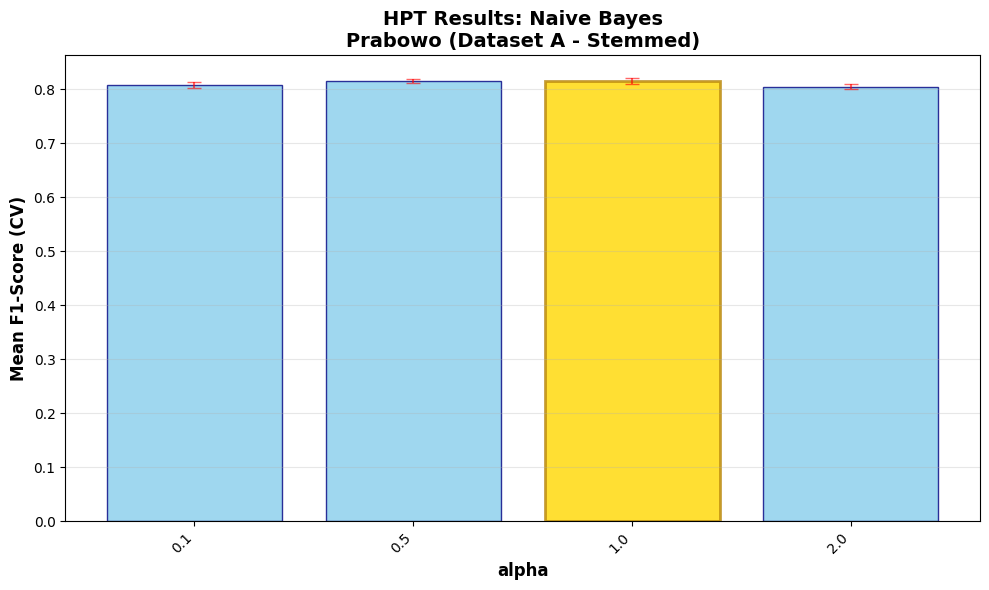

✓ Training completed

Prabowo (Dataset A - Stemmed) - Naive Bayes - EVALUATION RESULTS

Accuracy:  0.8224
Precision: 0.8226
Recall:    0.8224
F1-Score:  0.8220

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.83      0.79      0.81       593
    Positive       0.82      0.85      0.84       668

    accuracy                           0.82      1261
   macro avg       0.82      0.82      0.82      1261
weighted avg       0.82      0.82      0.82      1261


--- Confusion Matrix ---
[[466 127]
 [ 97 571]]


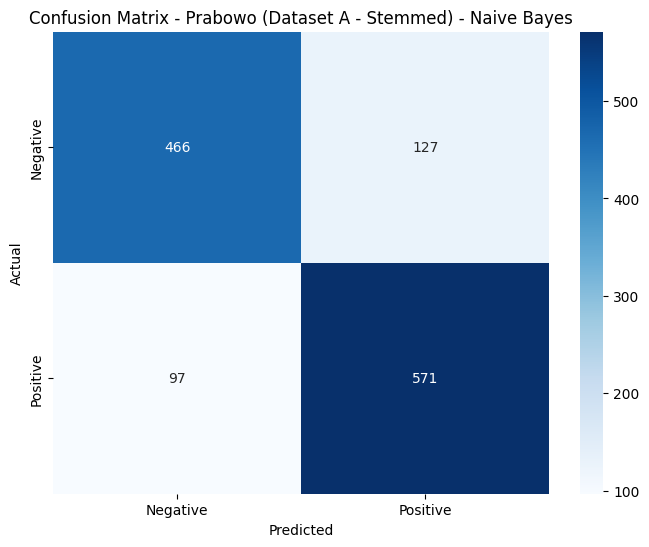


[2/5] Training SVM (Linear Kernel)...

🔍 Running HPT for SVM ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
✓ Best params for SVM: {'C': 5, 'kernel': 'linear'}
✓ Best score: 0.8835

📊 Top 5 Configurations for SVM:
                        params  mean_test_score  std_test_score  rank_test_score
  {'C': 5, 'kernel': 'linear'}         0.883528        0.006289                1
  {'C': 1, 'kernel': 'linear'}         0.873835        0.012330                2
{'C': 0.1, 'kernel': 'linear'}         0.809885        0.014687                3


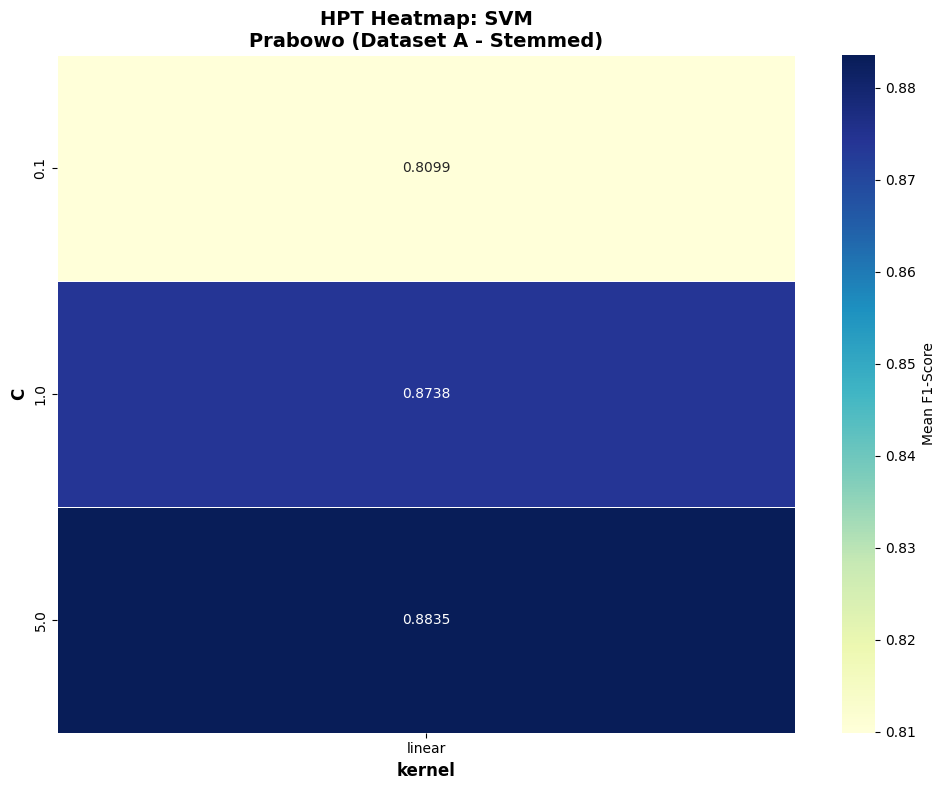

✓ Training completed

Prabowo (Dataset A - Stemmed) - SVM - EVALUATION RESULTS

Accuracy:  0.8866
Precision: 0.8866
Recall:    0.8866
F1-Score:  0.8866

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88       593
    Positive       0.89      0.90      0.89       668

    accuracy                           0.89      1261
   macro avg       0.89      0.89      0.89      1261
weighted avg       0.89      0.89      0.89      1261


--- Confusion Matrix ---
[[520  73]
 [ 70 598]]


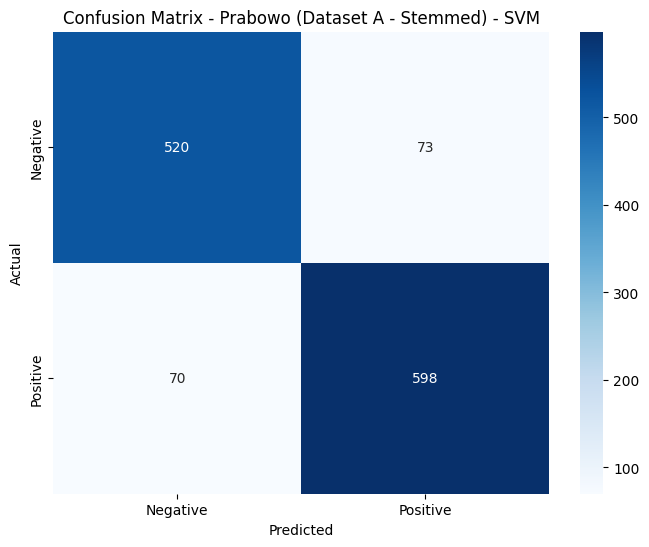


[3/5] Training Random Forest...

🔍 Running HPT for Random Forest ...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✓ Best params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
✓ Best score: 0.8332

📊 Top 5 Configurations for Random Forest:
                                                          params  mean_test_score  std_test_score  rank_test_score
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}         0.833174        0.013935                1
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}         0.831927        0.014473                2
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}         0.831152        0.010618                3
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}         0.830059        0.014079                4
  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}         0.800511        0.012190                5


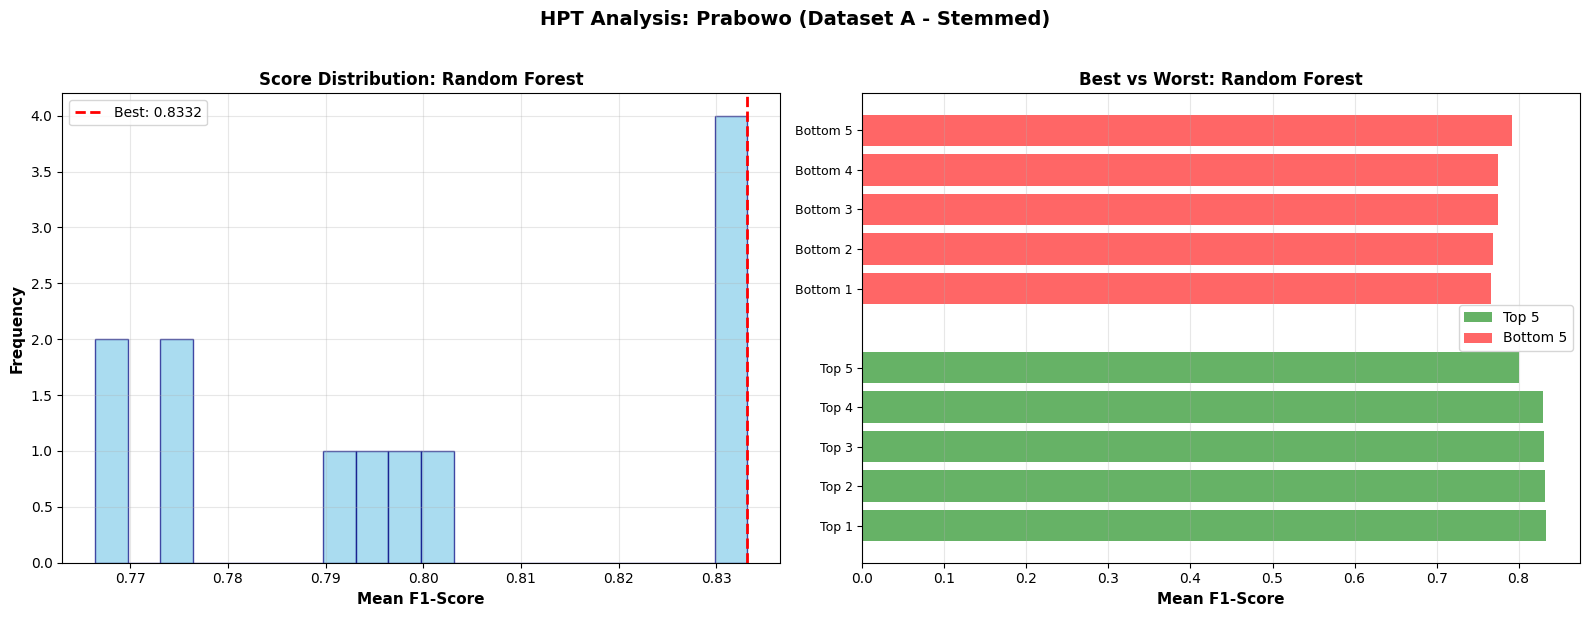

✓ Training completed

Prabowo (Dataset A - Stemmed) - Random Forest - EVALUATION RESULTS

Accuracy:  0.8279
Precision: 0.8278
Recall:    0.8279
F1-Score:  0.8278

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.82      0.81      0.82       593
    Positive       0.83      0.84      0.84       668

    accuracy                           0.83      1261
   macro avg       0.83      0.83      0.83      1261
weighted avg       0.83      0.83      0.83      1261


--- Confusion Matrix ---
[[480 113]
 [104 564]]


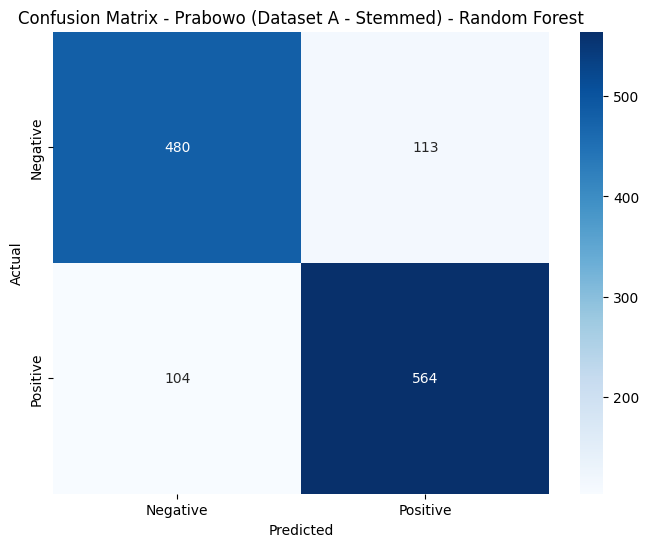


[4/5] Training IndoBERT...

[Training IndoBERT for Prabowo (Dataset A - Stemmed)]
Loading IndoBERT tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded
Preparing datasets...


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Training IndoBERT...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.352500,0.404088,0.847740
2,0.333000,0.300026,0.868358
3,0.040800,0.433579,0.900079


✓ Training completed
Evaluating IndoBERT...



IndoBERT Results:
Accuracy:  0.9001
Precision: 0.9005
Recall:    0.9001
F1-Score:  0.9001


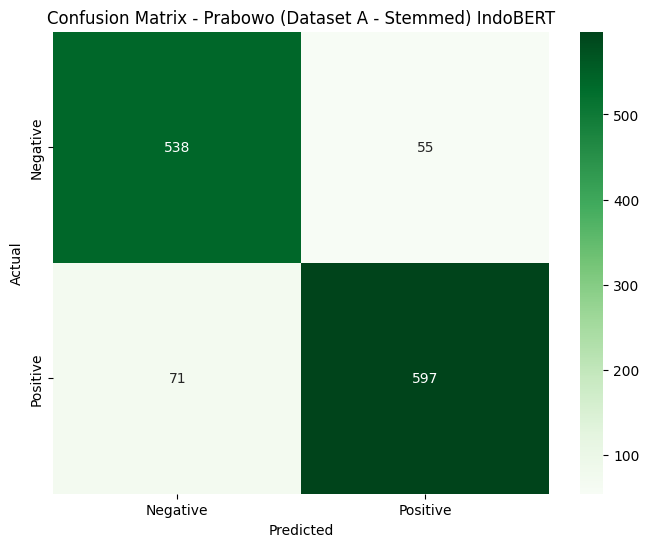


[5/5] Training Ensemble Model (Voting)...

🔍 Running HPT for Ensemble ...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
✓ Best params for Ensemble: {'weights': [1, 2, 1]}
✓ Best score: 0.8835

📊 Top 5 Configurations for Ensemble:
                params  mean_test_score  std_test_score  rank_test_score
{'weights': [1, 2, 1]}         0.883489        0.011290                1
{'weights': [1, 2, 2]}         0.883294        0.009362                2
{'weights': [1, 1, 1]}         0.880725        0.009940                3
{'weights': [2, 2, 1]}         0.880506        0.010234                4
{'weights': [1, 1, 2]}         0.877084        0.009561                5


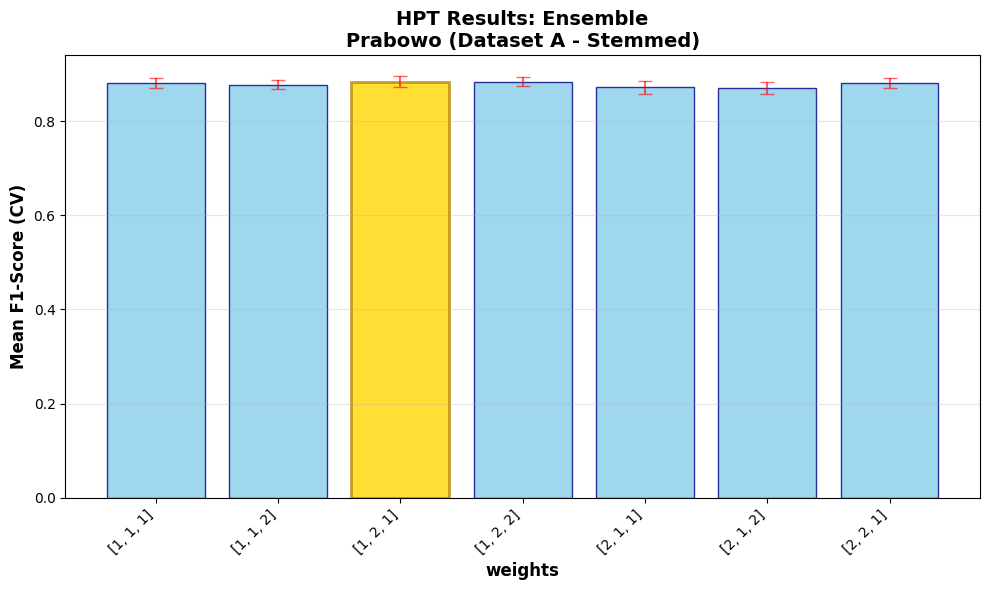

✓ Training completed

Prabowo (Dataset A - Stemmed) - Ensemble - EVALUATION RESULTS

Accuracy:  0.8850
Precision: 0.8850
Recall:    0.8850
F1-Score:  0.8849

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.88       593
    Positive       0.89      0.90      0.89       668

    accuracy                           0.89      1261
   macro avg       0.89      0.88      0.88      1261
weighted avg       0.89      0.89      0.88      1261


--- Confusion Matrix ---
[[515  78]
 [ 67 601]]


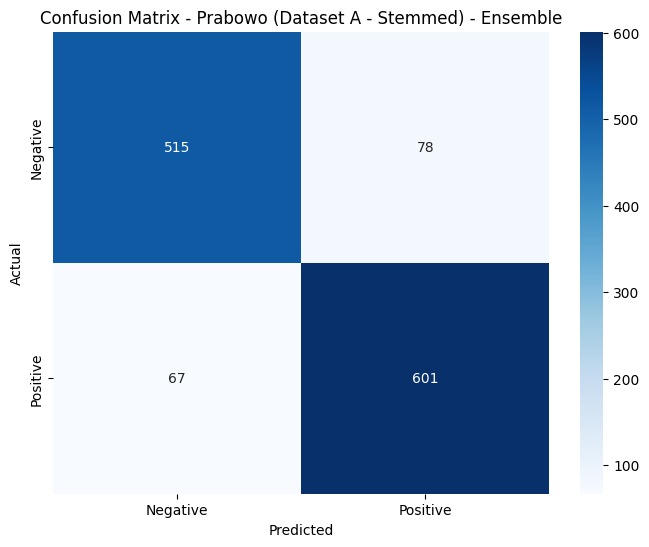


############################################################
DATASET B (WITHOUT STEMMING) - PRABOWO
############################################################
DEBUG: Loading data for prabowo with method inset_no_stemming
DEBUG: Checking path: /kaggle/working/labeled/prabowo_inset_no_stemming_binary.csv

PRABOWO - INSET_NO_STEMMING Dataset:
Total samples: 6165
Label distribution: {1: 4151, 0: 2014}

############################################################
TRAINING MODELS - Prabowo (Dataset B - No Stemming)
############################################################

[1/5] Training Multinomial Naive Bayes...

🔍 Running HPT for Naive Bayes ...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✓ Best params for Naive Bayes: {'alpha': 0.1}
✓ Best score: 0.8177

📊 Top 5 Configurations for Naive Bayes:
        params  mean_test_score  std_test_score  rank_test_score
{'alpha': 0.1}         0.817662        0.009080                1
{'alpha': 0.5}         0.807855        0.0043

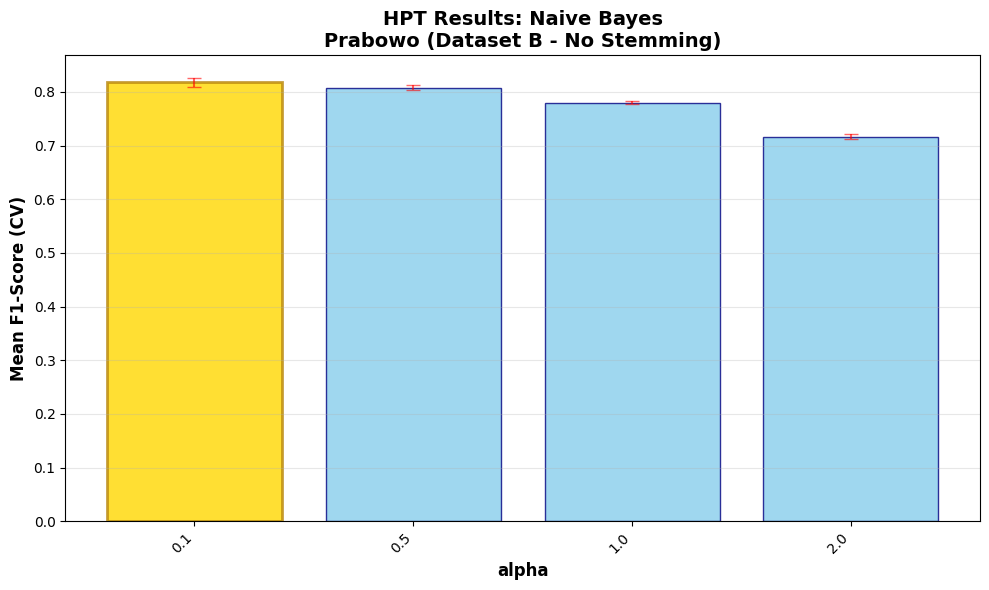

✓ Training completed

Prabowo (Dataset B - No Stemming) - Naive Bayes - EVALUATION RESULTS

Accuracy:  0.8273
Precision: 0.8252
Recall:    0.8273
F1-Score:  0.8259

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.75      0.71      0.73       403
    Positive       0.86      0.89      0.87       830

    accuracy                           0.83      1233
   macro avg       0.81      0.80      0.80      1233
weighted avg       0.83      0.83      0.83      1233


--- Confusion Matrix ---
[[285 118]
 [ 95 735]]


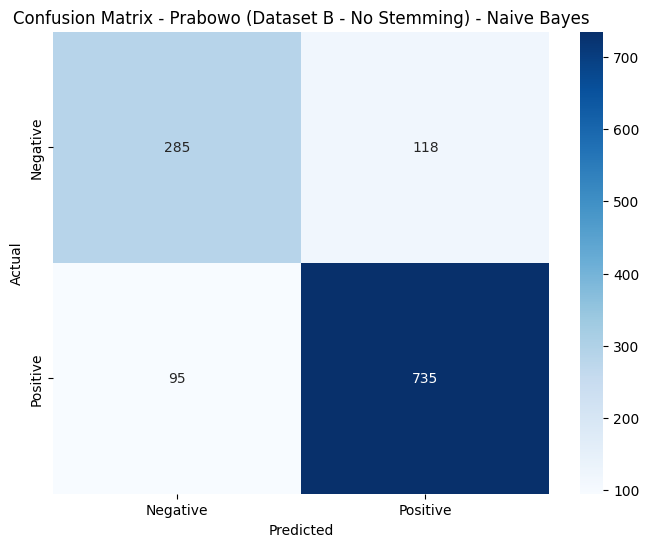


[2/5] Training SVM (Linear Kernel)...

🔍 Running HPT for SVM ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
✓ Best params for SVM: {'C': 5, 'kernel': 'linear'}
✓ Best score: 0.8627

📊 Top 5 Configurations for SVM:
                        params  mean_test_score  std_test_score  rank_test_score
  {'C': 5, 'kernel': 'linear'}         0.862726        0.007602                1
  {'C': 1, 'kernel': 'linear'}         0.850706        0.004034                2
{'C': 0.1, 'kernel': 'linear'}         0.608442        0.004843                3


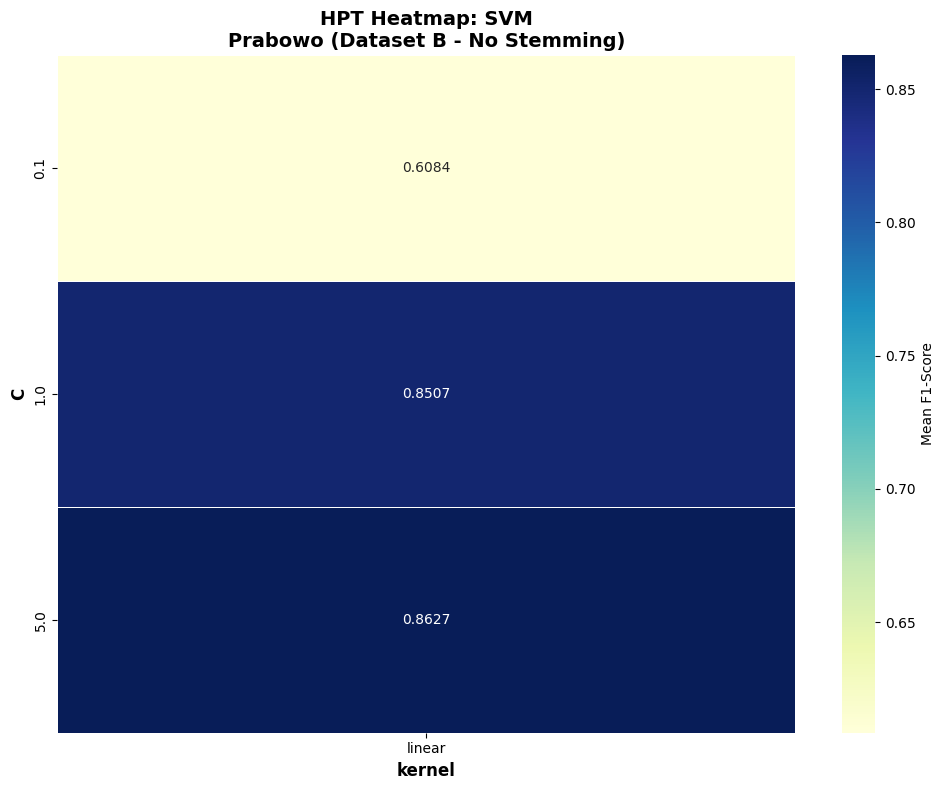

✓ Training completed

Prabowo (Dataset B - No Stemming) - SVM - EVALUATION RESULTS

Accuracy:  0.8832
Precision: 0.8825
Recall:    0.8832
F1-Score:  0.8827

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.83      0.81      0.82       403
    Positive       0.91      0.92      0.91       830

    accuracy                           0.88      1233
   macro avg       0.87      0.86      0.87      1233
weighted avg       0.88      0.88      0.88      1233


--- Confusion Matrix ---
[[325  78]
 [ 66 764]]


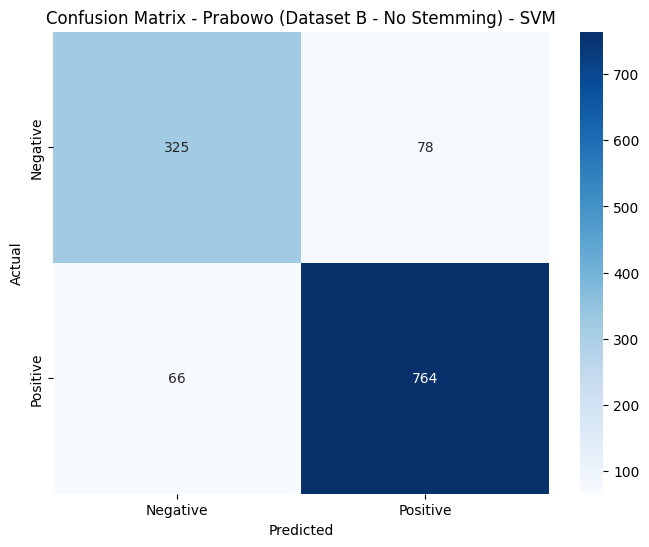


[3/5] Training Random Forest...

🔍 Running HPT for Random Forest ...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✓ Best params for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
✓ Best score: 0.8111

📊 Top 5 Configurations for Random Forest:
                                                          params  mean_test_score  std_test_score  rank_test_score
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}         0.811077        0.003890                1
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}         0.809130        0.001795                2
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}         0.808108        0.003834                3
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}         0.804616        0.005880                4
  {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}         0.696017        0.001164                5


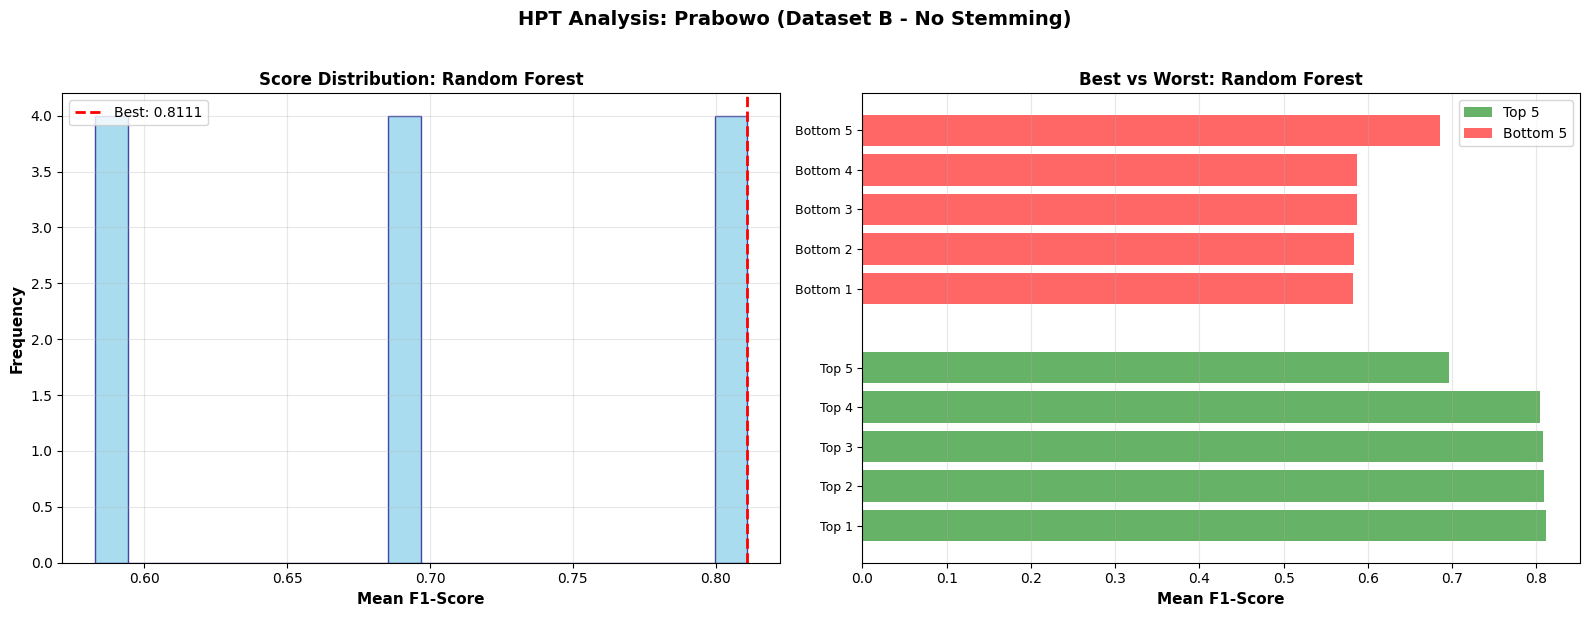

✓ Training completed

Prabowo (Dataset B - No Stemming) - Random Forest - EVALUATION RESULTS

Accuracy:  0.8297
Precision: 0.8285
Recall:    0.8297
F1-Score:  0.8225

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.82      0.62      0.70       403
    Positive       0.83      0.93      0.88       830

    accuracy                           0.83      1233
   macro avg       0.83      0.77      0.79      1233
weighted avg       0.83      0.83      0.82      1233


--- Confusion Matrix ---
[[248 155]
 [ 55 775]]


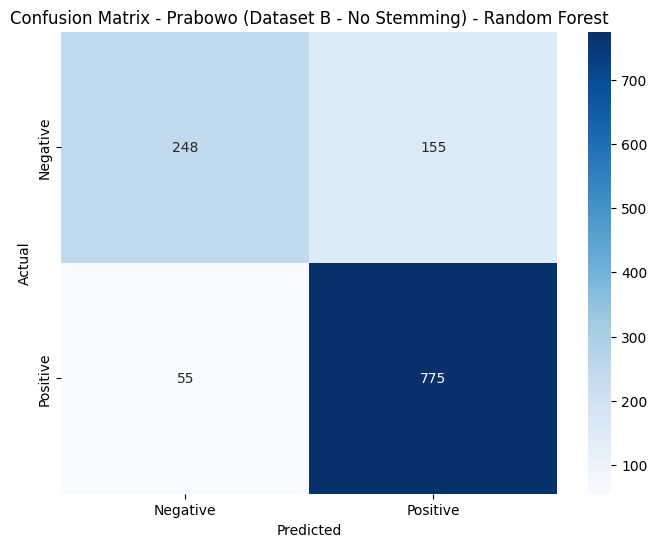


[4/5] Training IndoBERT...

[Training IndoBERT for Prabowo (Dataset B - No Stemming)]
Loading IndoBERT tokenizer and model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded
Preparing datasets...
Training IndoBERT...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.457600,0.470786,0.784266
2,0.337100,0.506114,0.824006
3,0.103700,0.408573,0.879157


✓ Training completed
Evaluating IndoBERT...



IndoBERT Results:
Accuracy:  0.8792
Precision: 0.8810
Recall:    0.8792
F1-Score:  0.8798


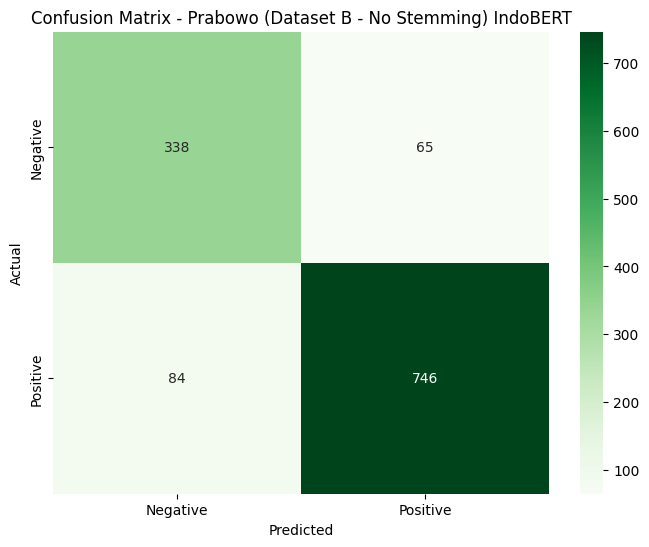


[5/5] Training Ensemble Model (Voting)...

🔍 Running HPT for Ensemble ...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
✓ Best params for Ensemble: {'weights': [1, 2, 1]}
✓ Best score: 0.8574

📊 Top 5 Configurations for Ensemble:
                params  mean_test_score  std_test_score  rank_test_score
{'weights': [1, 2, 1]}         0.857394        0.002881                1
{'weights': [2, 2, 1]}         0.852242        0.002230                2
{'weights': [1, 2, 2]}         0.852169        0.005894                3
{'weights': [1, 1, 1]}         0.848606        0.003227                4
{'weights': [1, 1, 2]}         0.847378        0.008480                5


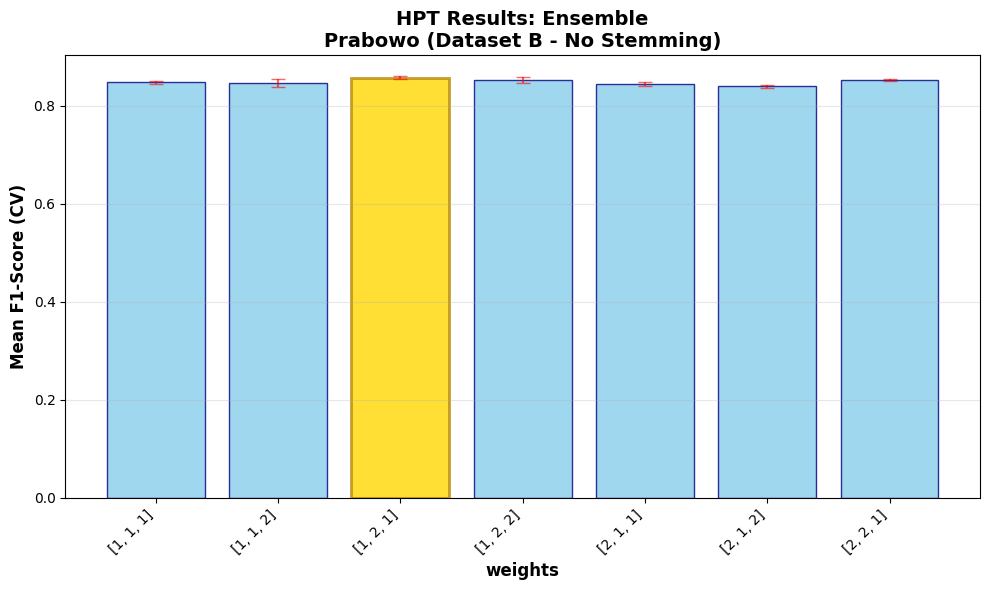

✓ Training completed

Prabowo (Dataset B - No Stemming) - Ensemble - EVALUATION RESULTS

Accuracy:  0.8840
Precision: 0.8828
Recall:    0.8840
F1-Score:  0.8826

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.85      0.78      0.81       403
    Positive       0.90      0.93      0.92       830

    accuracy                           0.88      1233
   macro avg       0.88      0.86      0.87      1233
weighted avg       0.88      0.88      0.88      1233


--- Confusion Matrix ---
[[314  89]
 [ 54 776]]


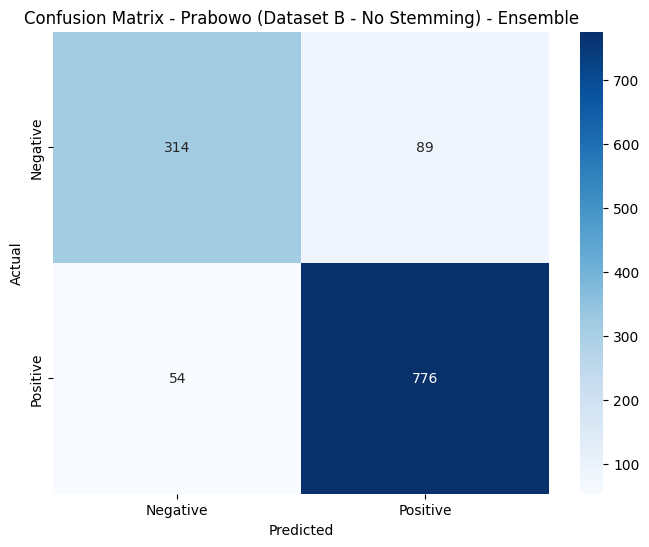


TRAINING COMPLETED FOR PRABOWO

📌 Kandidat selesai: prabowo
📌 Total hasil Dataset A: 5
📌 Total hasil Dataset B: 5

⚠️ UNTUK KANDIDAT SELANJUTNYA:
   1. Ganti CURRENT_CANDIDATE di atas
   2. Jalankan ulang cell ini
   3. Setelah semua 3 kandidat selesai, jalankan cell visualisasi


In [25]:
# SKENARIO 2: TRAINING PER CANDIDATE - COMPARISON WITH vs WITHOUT STEMMING
# ============================================================================
# UBAH KANDIDAT DI SINI: 'anies', 'ganjar', atau 'prabowo'
# ============================================================================
CURRENT_CANDIDATE = 'prabowo'  # <-- GANTI INI UNTUK KANDIDAT LAIN
# ============================================================================

# Storage for all results (akan di-append setiap run)
# Jalankan cell ini untuk setiap kandidat, lalu jalankan cell visualisasi
if 'results_comparison' not in dir():
    results_comparison = {
        'Dataset A (With Stemming)': [],
        'Dataset B (Without Stemming)': []
    }
    all_models_stemmed = {}
    all_models_no_stem = {}

print("=" * 80)
print(f"SKENARIO 2: TRAINING KANDIDAT - {CURRENT_CANDIDATE.upper()}")
print("=" * 80)

candidate = CURRENT_CANDIDATE

print("\n" + "=" * 80)
print(f"CANDIDATE: {candidate.upper()}")
print("=" * 80)

# ========================================================================
# DATASET A: WITH STEMMING
# ========================================================================
print(f"\n{'#' * 60}")
print(f"DATASET A (WITH STEMMING) - {candidate.upper()}")
print('#' * 60)

X_text_stemmed, y_stemmed, _ = load_candidate_data(candidate, method='inset_stemmed')

if X_text_stemmed is not None:
    # TF-IDF Vectorization
    tfidf_stemmed = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95, sublinear_tf=True)
    X_tfidf_stemmed = tfidf_stemmed.fit_transform(X_text_stemmed)
    
    # Train-test split
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_tfidf_stemmed, y_stemmed, test_size=0.2, random_state=42, stratify=y_stemmed
    )
    
    # Split texts for IndoBERT
    texts_train_s, texts_test_s, _, _ = train_test_split(
        X_text_stemmed, y_stemmed, test_size=0.2, random_state=42, stratify=y_stemmed
    )
    
    # Train models
    method_name = f"{candidate.capitalize()} (Dataset A - Stemmed)"
    results_s, models_s, hpt_s = train_and_evaluate(
        X_train_s, X_test_s, y_train_s, y_test_s,
        texts_train_s, texts_test_s,
        method_name=method_name
    )
    
    results_comparison['Dataset A (With Stemming)'].extend(results_s)
    all_models_stemmed[candidate] = models_s
    
    # Clear memory
    del X_tfidf_stemmed, X_train_s, X_test_s, texts_train_s, texts_test_s
    import gc
    gc.collect()

# ========================================================================
# DATASET B: WITHOUT STEMMING
# ========================================================================
print(f"\n{'#' * 60}")
print(f"DATASET B (WITHOUT STEMMING) - {candidate.upper()}")
print('#' * 60)

X_text_no_stem, y_no_stem, _ = load_candidate_data(candidate, method='inset_no_stemming')

if X_text_no_stem is not None:
    # TF-IDF Vectorization
    tfidf_no_stem = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95, sublinear_tf=True)
    X_tfidf_no_stem = tfidf_no_stem.fit_transform(X_text_no_stem)
    
    # Train-test split
    X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
        X_tfidf_no_stem, y_no_stem, test_size=0.2, random_state=42, stratify=y_no_stem
    )
    
    # Split texts for IndoBERT
    texts_train_ns, texts_test_ns, _, _ = train_test_split(
        X_text_no_stem, y_no_stem, test_size=0.2, random_state=42, stratify=y_no_stem
    )
    
    # Train models
    method_name = f"{candidate.capitalize()} (Dataset B - No Stemming)"
    results_ns, models_ns, hpt_ns = train_and_evaluate(
        X_train_ns, X_test_ns, y_train_ns, y_test_ns,
        texts_train_ns, texts_test_ns,
        method_name=method_name
    )
    
    results_comparison['Dataset B (Without Stemming)'].extend(results_ns)
    all_models_no_stem[candidate] = models_ns
    
    # Clear memory
    del X_tfidf_no_stem, X_train_ns, X_test_ns, texts_train_ns, texts_test_ns
    import gc
    gc.collect()

print("\n" + "=" * 80)
print(f"TRAINING COMPLETED FOR {candidate.upper()}")
print("=" * 80)
print(f"\n📌 Kandidat selesai: {candidate}")
print(f"📌 Total hasil Dataset A: {len(results_comparison['Dataset A (With Stemming)'])}")
print(f"📌 Total hasil Dataset B: {len(results_comparison['Dataset B (Without Stemming)'])}")
print("\n⚠️ UNTUK KANDIDAT SELANJUTNYA:")
print("   1. Ganti CURRENT_CANDIDATE di atas")
print("   2. Jalankan ulang cell ini")
print("   3. Setelah semua 3 kandidat selesai, jalankan cell visualisasi")
print("=" * 80)

SKENARIO 2: HASIL PERBANDINGAN

TABEL PERBANDINGAN PERFORMA MODEL
                     Dataset                                             Model  Accuracy  Precision   Recall  F1-Score
   Dataset A (With Stemming)       Prabowo (Dataset A - Stemmed) - Naive Bayes  0.822363   0.822593 0.822363  0.822009
   Dataset A (With Stemming)               Prabowo (Dataset A - Stemmed) - SVM  0.886598   0.886575 0.886598  0.886581
   Dataset A (With Stemming)     Prabowo (Dataset A - Stemmed) - Random Forest  0.827914   0.827835 0.827914  0.827832
   Dataset A (With Stemming)          Prabowo (Dataset A - Stemmed) - IndoBERT  0.900079   0.900488 0.900079  0.900139
   Dataset A (With Stemming)          Prabowo (Dataset A - Stemmed) - Ensemble  0.885012   0.885010 0.885012  0.884943
Dataset B (Without Stemming)   Prabowo (Dataset B - No Stemming) - Naive Bayes  0.827251   0.825168 0.827251  0.825894
Dataset B (Without Stemming)           Prabowo (Dataset B - No Stemming) - SVM  0.883212   0.882470 0

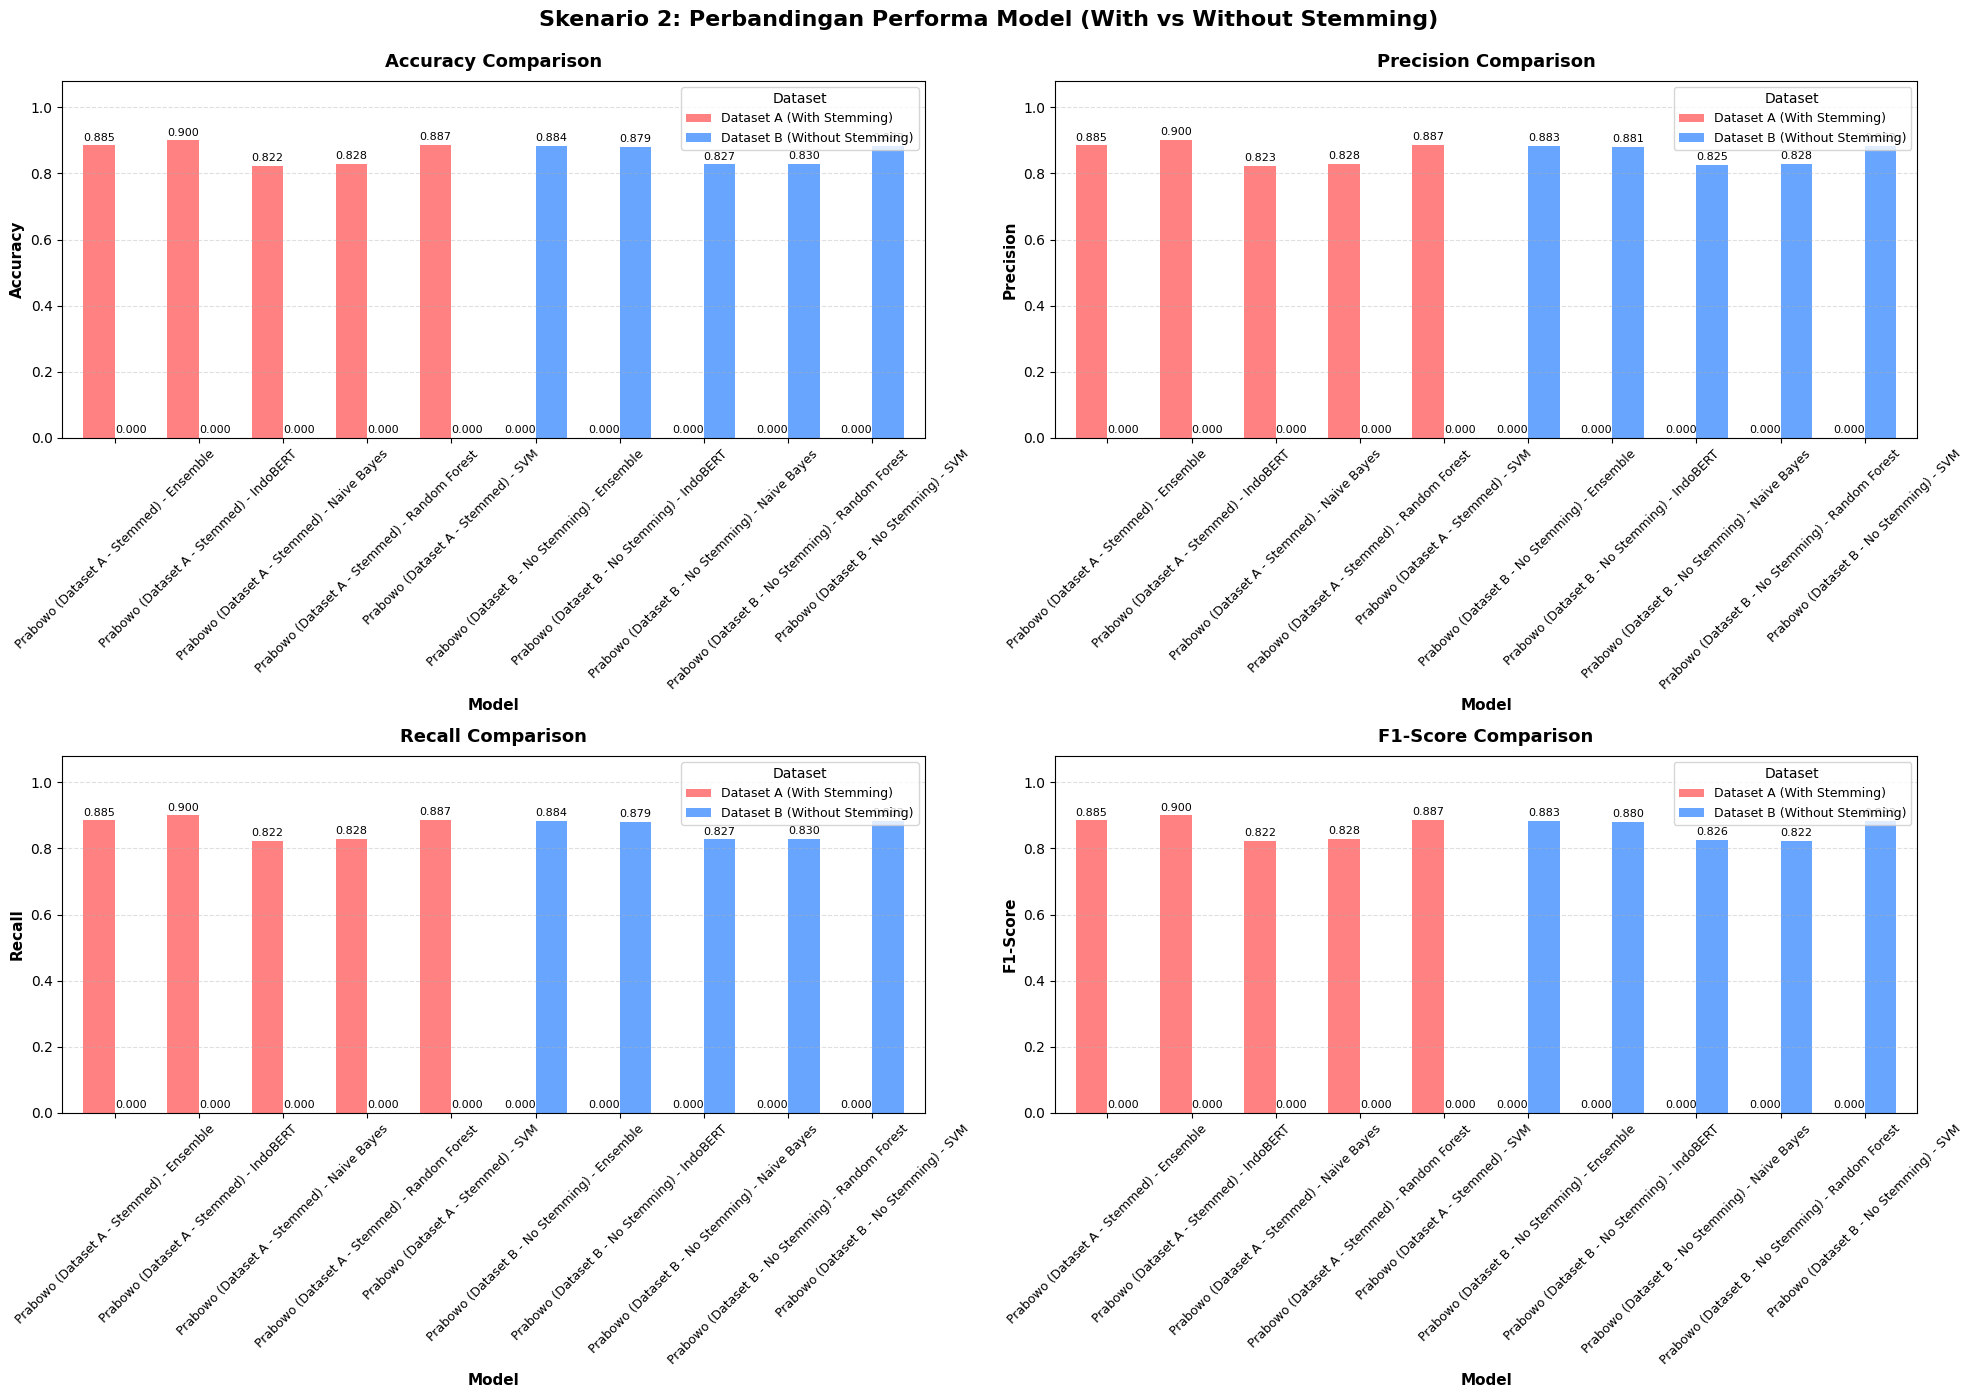

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (5,).

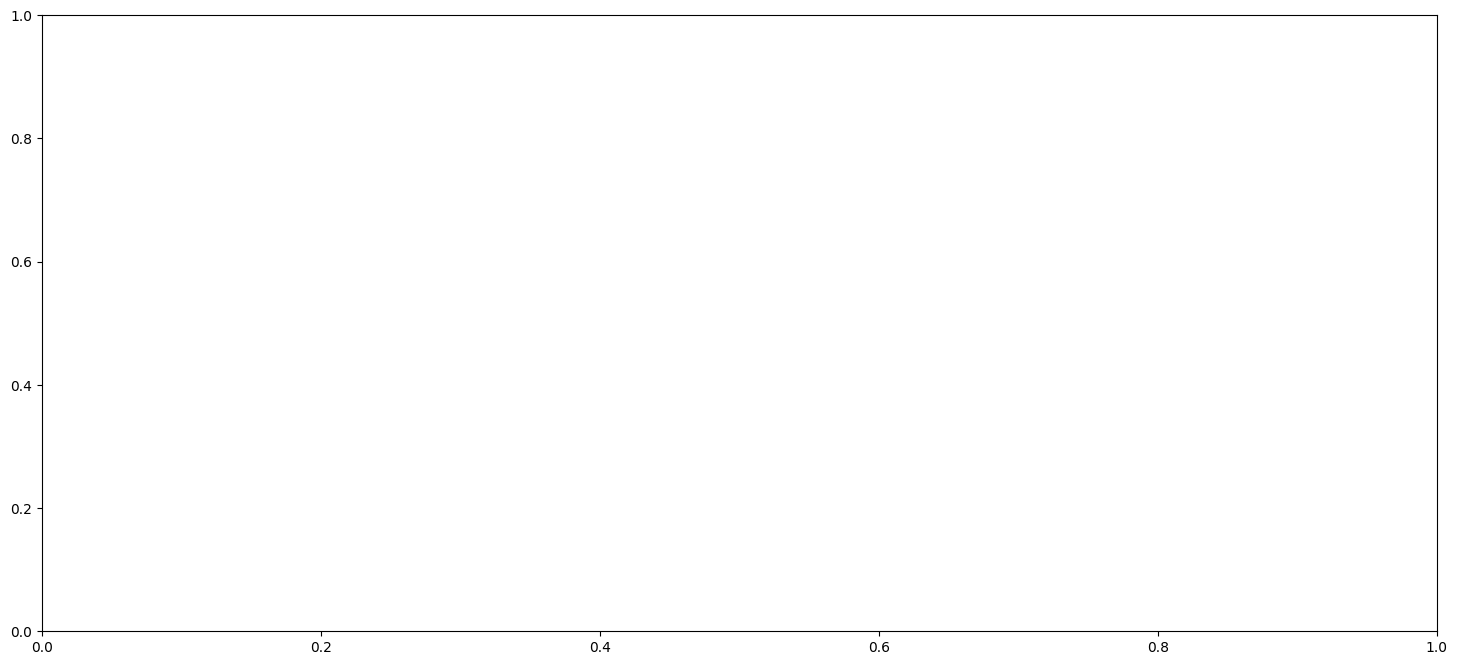

In [26]:
# COMPARISON VISUALIZATION FOR SKENARIO 2

print("=" * 80)
print("SKENARIO 2: HASIL PERBANDINGAN")
print("=" * 80)

# Prepare comparison data
comparison_data = []
for dataset_name, results in results_comparison.items():
    for result in results:
        comparison_data.append({
            'Dataset': dataset_name,
            'Model': result['model'].replace(' - Dataset A', '').replace(' - Dataset B', ''),
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1']
        })

df_comparison = pd.DataFrame(comparison_data)

# Display comparison table
print("\n" + "=" * 80)
print("TABEL PERBANDINGAN PERFORMA MODEL")
print("=" * 80)
print(df_comparison.to_string(index=False))
print("=" * 80)

# === VISUALIZATION 1: Bar Chart Comparison (All Metrics) ===
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, axes = plt.subplots(2, 2, figsize=(20, 14))  # Increased size for 5 models
fig.suptitle('Skenario 2: Perbandingan Performa Model (With vs Without Stemming)', 
             fontsize=16, fontweight='bold', y=0.995)

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Prepare data for plotting
    pivot_data = df_comparison.pivot(index='Model', columns='Dataset', values=metric)
    
    # Plot with adjusted bar width
    pivot_data.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4D96FF'], alpha=0.85, width=0.75)
    
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_xlabel('Model', fontsize=11, fontweight='bold')
    ax.set_ylim(0, 1.08)
    ax.legend(title='Dataset', fontsize=9, loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=8, padding=2)

plt.tight_layout()
plt.savefig(os.path.join(PICTURES_DIR, 'skenario2_comparison_bars.png'), dpi=200, bbox_inches='tight')
plt.show()

# === VISUALIZATION 2: Grouped Bar Chart F1-Score ===
fig, ax = plt.subplots(figsize=(18, 8))  # Wider for 5 models

x = np.arange(len(df_comparison['Model'].unique()))
width = 0.35

# Data for Dataset A and B
dataset_a = df_comparison[df_comparison['Dataset'] == 'Dataset A (With Stemming)']
dataset_b = df_comparison[df_comparison['Dataset'] == 'Dataset B (Without Stemming)']

# Plot bars
bars1 = ax.bar(x - width/2, dataset_a['F1-Score'], width, label='Dataset A (With Stemming)', 
               color='#FF6B6B', alpha=0.85, edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x + width/2, dataset_b['F1-Score'], width, label='Dataset B (Without Stemming)', 
               color='#4D96FF', alpha=0.85, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title('Skenario 2: Perbandingan F1-Score Model pada Dataset A vs Dataset B', 
             fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(dataset_a['Model'], fontsize=11, rotation=0)
ax.legend(fontsize=12, loc='upper right')
ax.set_ylim(0, 1.08)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Add value labels
ax.bar_label(bars1, fmt='%.3f', fontsize=10, padding=3, fontweight='bold')
ax.bar_label(bars2, fmt='%.3f', fontsize=10, padding=3, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PICTURES_DIR, 'skenario2_f1_comparison.png'), dpi=200, bbox_inches='tight')
plt.show()

# === VISUALIZATION 3: Heatmap Comparison ===
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Skenario 2: Heatmap Performa Model', fontsize=16, fontweight='bold', y=0.98)

for idx, dataset_name in enumerate(['Dataset A (With Stemming)', 'Dataset B (Without Stemming)']):
    ax = axes[idx]
    
    # Filter data
    dataset_data = df_comparison[df_comparison['Dataset'] == dataset_name]
    
    # Prepare heatmap data
    heatmap_data = dataset_data.set_index('Model')[metrics]
    
    # Plot heatmap
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='YlOrRd', 
                ax=ax, cbar_kws={'label': 'Score'}, linewidths=0.5, 
                vmin=0, vmax=1, linecolor='gray')
    
    ax.set_title(dataset_name, fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Model', fontsize=11, fontweight='bold')
    ax.set_ylabel('Metrics', fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.savefig(os.path.join(PICTURES_DIR, 'skenario2_heatmap.png'), dpi=200, bbox_inches='tight')
plt.show()

# === VISUALIZATION 4: Difference Analysis ===
print("\n" + "=" * 80)
print("ANALISIS PERBEDAAN PERFORMA (Dataset A - Dataset B)")
print("=" * 80)

difference_analysis = []
for model in df_comparison['Model'].unique():
    model_a = df_comparison[(df_comparison['Model'] == model) & 
                            (df_comparison['Dataset'] == 'Dataset A (With Stemming)')].iloc[0]
    model_b = df_comparison[(df_comparison['Model'] == model) & 
                            (df_comparison['Dataset'] == 'Dataset B (Without Stemming)')].iloc[0]
    
    diff = {
        'Model': model,
        'Accuracy Δ': model_a['Accuracy'] - model_b['Accuracy'],
        'Precision Δ': model_a['Precision'] - model_b['Precision'],
        'Recall Δ': model_a['Recall'] - model_b['Recall'],
        'F1-Score Δ': model_a['F1-Score'] - model_b['F1-Score']
    }
    difference_analysis.append(diff)

df_diff = pd.DataFrame(difference_analysis)
print(df_diff.to_string(index=False))
print("\n⚠️ Nilai positif (+) = Dataset A (With Stemming) lebih baik")
print("⚠️ Nilai negatif (-) = Dataset B (Without Stemming) lebih baik")
print("=" * 80)

# === Bar Chart: Difference Visualization ===
fig, ax = plt.subplots(figsize=(18, 8))

x = np.arange(len(df_diff))
width = 0.2

colors = ['#FF6B6B', '#4ECDC4', '#FFD93D', '#95E1D3']
diff_metrics = ['Accuracy Δ', 'Precision Δ', 'Recall Δ', 'F1-Score Δ']

for i, (metric, color) in enumerate(zip(diff_metrics, colors)):
    offset = width * (i - 1.5)
    bars = ax.bar(x + offset, df_diff[metric], width, label=metric, alpha=0.85, color=color)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}',
               ha='center', va='bottom' if height >= 0 else 'top', 
               fontsize=9, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2)
ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_ylabel('Performance Difference (Dataset A - Dataset B)', fontsize=13, fontweight='bold')
ax.set_title('Skenario 2: Analisis Perbedaan Performa\nPositif = Stemming Better | Negatif = No Stemming Better', 
             fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(df_diff['Model'], fontsize=11, rotation=0)
ax.legend(fontsize=11, ncol=4, loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig(os.path.join(PICTURES_DIR, 'skenario2_difference_bars.png'), dpi=200, bbox_inches='tight')
plt.show()

# === VISUALIZATION 5: Heatmap of Differences ===
fig, ax = plt.subplots(figsize=(12, 7))
diff_matrix = df_diff.set_index('Model')
sns.heatmap(diff_matrix, annot=True, fmt='.4f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Performance Difference'}, linewidths=1, ax=ax,
            vmin=-0.1, vmax=0.1)
ax.set_title('Skenario 2: Heatmap Perbedaan Performa\n(Dataset A - Dataset B)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=11)
ax.set_ylabel('Model', fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(PICTURES_DIR, 'skenario2_difference_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("VISUALISASI PERBANDINGAN SELESAI")
print("=" * 80)

## Hyperparameter Summary

In [ ]:
# HPT Summary Report (SKENARIO 2)
print("=" * 80)
print("SKENARIO 2: HYPERPARAMETER TUNING SUMMARY")
print("=" * 80)

hpt_summary_data = []

for key, hpt_dict in skenario2_hpt_results.items():
    candidate_method = key  # e.g., 'anies_with_stemming'
    
    for model_name, cv_results in hpt_dict.items():
        # Get best result
        best_idx = cv_results['mean_test_score'].idxmax()
        best_row = cv_results.loc[best_idx]
        
        # Extract parameters
        param_cols = [col for col in cv_results.columns if col.startswith('param_')]
        best_params = {col.replace('param_', ''): best_row[col] for col in param_cols}
        
        # Parse dataset type from key (e.g., 'anies_with_stemming' or 'anies_without_stemming')
        parts = candidate_method.split('_')
        candidate = parts[0].capitalize()
        dataset_type = 'With Stemming' if 'with' in candidate_method else 'Without Stemming'
        
        hpt_summary_data.append({
            'Candidate': candidate,
            'Dataset': dataset_type,
            'Model': model_name.upper(),
            'Best_Score': best_row['mean_test_score'],
            'Std_Dev': best_row['std_test_score'],
            'Best_Params': str(best_params),
            'Total_Configs': len(cv_results)
        })

# Create DataFrame
df_hpt_summary = pd.DataFrame(hpt_summary_data)

print("\n📊 Complete HPT Summary Table:")
print(df_hpt_summary.to_string(index=False))

# Save to CSV
hpt_summary_path = os.path.join(PROCESSED_DIR, 'skenario2_hpt_summary.csv')
df_hpt_summary.to_csv(hpt_summary_path, index=False)
print(f"\n✓ HPT Summary saved to: {hpt_summary_path}")

# Visualize HPT Summary
print("\n📈 Generating HPT Comparison Visualizations...")

# Plot 1: Best scores across all models and candidates
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# By Model Type
ax1 = axes[0]
model_scores = df_hpt_summary.groupby('Model')['Best_Score'].mean().sort_values(ascending=True)
colors_model = plt.cm.viridis(np.linspace(0.2, 0.9, len(model_scores)))
bars1 = ax1.barh(range(len(model_scores)), model_scores.values, color=colors_model)
ax1.set_yticks(range(len(model_scores)))
ax1.set_yticklabels(model_scores.index, fontsize=11)
ax1.set_xlabel('Average Best F1-Score', fontsize=12, fontweight='bold')
ax1.set_title('HPT Results by Model Type\n(Averaged across all candidates)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, model_scores.values)):
    ax1.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

# By Candidate
ax2 = axes[1]
cand_scores = df_hpt_summary.groupby('Candidate')['Best_Score'].mean().sort_values(ascending=True)
colors_cand = ['#4D96FF', '#90EE90', '#FF6B6B']
bars2 = ax2.barh(range(len(cand_scores)), cand_scores.values, color=colors_cand)
ax2.set_yticks(range(len(cand_scores)))
ax2.set_yticklabels(cand_scores.index, fontsize=11)
ax2.set_xlabel('Average Best F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('HPT Results by Candidate\n(Averaged across all models)', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, cand_scores.values)):
    ax2.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PICTURES_DIR, 'hpt_summary_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Detailed heatmap of all combinations
print("\n📊 Generating detailed HPT heatmap...")

pivot_hpt = df_hpt_summary.pivot_table(
    values='Best_Score',
    index=['Candidate', 'Method'],
    columns='Model',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_hpt, annot=True, fmt='.4f', cmap='RdYlGn', 
            linewidths=0.5, cbar_kws={'label': 'Best F1-Score'},
            vmin=pivot_hpt.min().min()-0.05, vmax=pivot_hpt.max().max())
plt.title('HPT Best Scores: All Models × Candidates × Methods', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Candidate (Method)', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PICTURES_DIR, 'skenario2_hpt_detailed_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Skenario 2 HPT Summary visualizations completed!")

## Model Comparison

In [ ]:
# Compare all models
print("=" * 80)
print("MODEL COMPARISON SUMMARY - PER CANDIDATE")
print("=" * 80)

# Create DataFrame from all results
df_results = pd.DataFrame(all_results)

print("\n--- Performance Metrics (All Candidates) ---")
print(df_results.to_string(index=False))

# Group by candidate
print("\n" + "=" * 80)
print("PERFORMANCE BY CANDIDATE")
print("=" * 80)

for candidate in ['Anies', 'Ganjar', 'Prabowo']:
    df_cand = df_results[df_results['model'].str.contains(candidate, case=False)]
    if len(df_cand) > 0:
        print(f"\n### {candidate.upper()} ###")
        print(df_cand[['model', 'accuracy', 'precision', 'recall', 'f1']].to_string(index=False))

# Visualize comparison - Per Candidate
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
metrics = ['accuracy', 'precision', 'recall', 'f1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    df_plot = df_results[['model', metric]].copy()
    
    # Color by candidate and method
    def get_color(model_name):
        if 'Anies' in model_name:
            return '#4D96FF' if 'InSet' in model_name else '#87CEEB'
        elif 'Ganjar' in model_name:
            return '#90EE90' if 'InSet' in model_name else '#98FB98'
        elif 'Prabowo' in model_name:
            return '#FF6B6B' if 'InSet' in model_name else '#FFA07A'
        return 'gray'
    
    colors = [get_color(m) for m in df_plot['model']]
    
    bars = ax.barh(df_plot['model'], df_plot[metric], color=colors)
    ax.set_xlabel(title, fontsize=11)
    ax.set_xlim(0, 1)
    ax.set_title(f'{title} Comparison (All Candidates)', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.tick_params(axis='y', labelsize=8)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', 
                ha='left', va='center', fontsize=7, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PICTURES_DIR, 'model_comparison_per_candidate.png'), dpi=150, bbox_inches='tight')
plt.show()

# Find best model overall
best_model = df_results.loc[df_results['f1'].idxmax()]
print(f"\n{'=' * 80}")
print("BEST MODEL OVERALL")
print('=' * 80)
print(f"Model: {best_model['model']}")
print(f"Accuracy:  {best_model['accuracy']:.4f}")
print(f"Precision: {best_model['precision']:.4f}")
print(f"Recall:    {best_model['recall']:.4f}")
print(f"F1-Score:  {best_model['f1']:.4f}")

# Best model per candidate
print(f"\n{'=' * 80}")
print("BEST MODEL PER CANDIDATE")
print('=' * 80)

for candidate in ['Anies', 'Ganjar', 'Prabowo']:
    df_cand = df_results[df_results['model'].str.contains(candidate, case=False)]
    if len(df_cand) > 0:
        best_cand = df_cand.loc[df_cand['f1'].idxmax()]
        print(f"\n{candidate.upper()}:")
        print(f"  Best Model: {best_cand['model']}")
        print(f"  F1-Score: {best_cand['f1']:.4f} | Accuracy: {best_cand['accuracy']:.4f}")

# Save results to CSV
df_results.to_csv(os.path.join(PROCESSED_DIR, 'model_results.csv'), index=False)
print(f"\n✓ Results saved to {os.path.join(PROCESSED_DIR, 'model_results.csv')}")